# Projet 7 : Implémentez un modèle de scoring 

#  Modélisation et Suivi par MLFlow 

AMAL DEMEHATI 

# 1. Introduction MLFlow 

MLflow est une plate-forme open source polyvalente et extensible pour la gestion des flux de travail et des artefacts tout au long du cycle de vie de l'apprentissage automatique. Il a des intégrations intégrées avec de nombreuses bibliothèques ML populaires, mais peut être utilisé avec n'importe quelle bibliothèque, algorithme ou outil de déploiement. Il est conçu pour être extensible, vous pouvez donc écrire des plugins pour prendre en charge de nouveaux workflows, bibliothèques et outils.

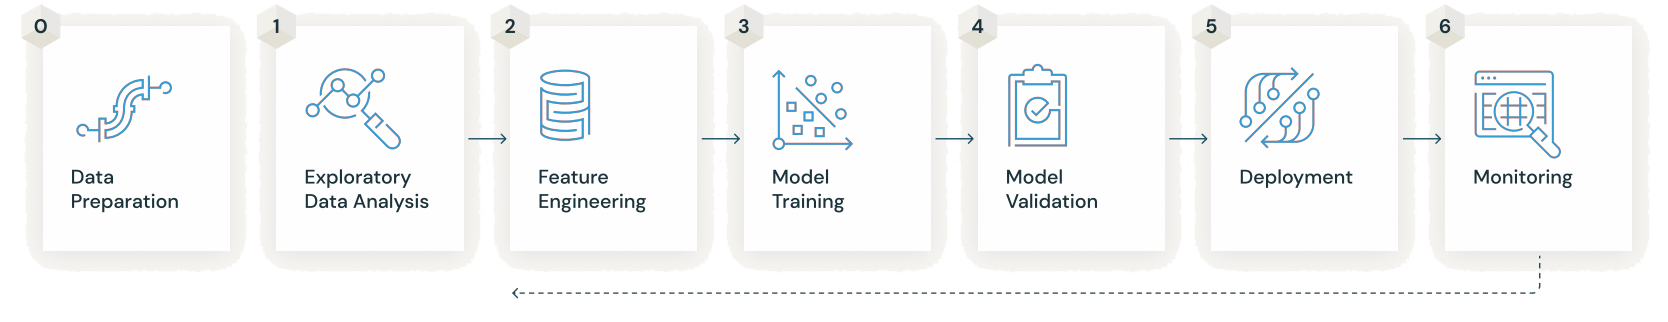

In [1]:
from IPython import display
display.Image(r"C:\Users\amalh\OneDrive\Bureau\mlflow-overview.png")

MLflow est utilisé pour gérer le cycle de vie de l'apprentissage automatique, du développement initial du modèle au déploiement et au-delà jusqu'à l'extinction. Il combine :

1. Suivi des expériences ML pour enregistrer et comparer les paramètres du modèle, évaluer les performances et gérer les artefacts (MLflow Tracking)

2. Conditionnement du code ML sous une forme réutilisable et reproductible afin de le partager avec d'autres data scientists ou de le transférer en production (MLflow Projects)

3. Empaqueter et déployer des modèles à partir d'une variété de bibliothèques ML vers une variété de plates-formes de service et d'inférence de modèles (modèles MLflow)

4. Gestion collaborative d'un magasin de modèles central, y compris la gestion des versions des modèles, les transitions d'étape et les annotations (MLflow Registry)

5. Accélération du développement itératif avec des modèles et des scripts réutilisables pour une variété de tâches de modélisation courantes (MLflow Recipes)

In [2]:
#Importing libraries and setting the experiment
import mlflow
import mlflow.sklearn

#mlflow.set_experiment('LearnML-Demo')

In [3]:
#Basic libraries
import pandas as pd
import seaborn as sns
import time, pickle
import numpy as np
from zipfile import ZipFile


#Metrics and models MLFLOW
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

#Operating system
import sys
import os

In [4]:
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [5]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\amalh\anaconda3\envs\Projet6\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [7]:
#MLFLow Metrics Evaluation
def eval_metrics(actual,pred):
    rmse=np.sqrt(mean_squared_error(actual,pred))
    mae=mean_absolute_error(actual,pred)
    r2=r2_score(actual,pred)
    return rmse, mae, r2

# 1. Lecture des données 

In [8]:
import pandas as pd

# Read in the CSV file without setting any index
data_train_csv = pd.read_csv('data_train_sans_valeurs_manquantes.csv', encoding='utf-8')

# Drop columns with names starting with "Unnamed"
cols_to_drop = [col for col in data_train_csv.columns if col.startswith('Unnamed')]
data_train_csv.drop(columns=cols_to_drop, inplace=True)

# Set 'SK_ID_CURR' as the index column
data_train = data_train_csv.set_index('SK_ID_CURR')

# Display the first few rows
print(data_train.head())


            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
0.000000             0.0          0.001512    0.090287     0.090032   
0.000003             0.0          0.002089    0.311736     0.132924   
0.000006             0.0          0.000358    0.022472     0.020025   
0.000011             0.0          0.000935    0.066837     0.109477   
0.000014             0.0          0.000819    0.116854     0.078975   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
0.000000           0.077441                    0.256321    0.111161   
0.000003           0.271605                    0.045016    0.522886   
0.000006           0.023569                    0.134897    0.651466   
0.000011           0.063973                    0.107023    0.649154   
0.000014           0.117845                    0.392880    0.701409   

    

In [9]:
TARGET2_csv=pd.read_csv('TARGET2.csv',index_col='SK_ID_CURR')
TARGET2=TARGET2_csv.copy()
TARGET2.head()

TARGET
SK_ID_CURR        
100002         1.0
100003         0.0
100004         0.0
100006         0.0
100007         0.0

In [10]:
data_train.shape

(307511, 312)

### Merging both train and target 

In [11]:
# 1. Set the index of TARGET2 to be the same as that of data_train
TARGET2.index = data_train.index

# 2. Rename the column if required
TARGET2 = TARGET2.rename(columns={TARGET2.columns[0]: 'TARGET2'})

# 3. Concatenate them
final_data = pd.concat([data_train, TARGET2], axis=1)

# Verify the result
print(final_data.shape)
final_data.head()





(307511, 313)


CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
0.000000             0.0          0.001512    0.090287     0.090032   
0.000003             0.0          0.002089    0.311736     0.132924   
0.000006             0.0          0.000358    0.022472     0.020025   
0.000011             0.0          0.000935    0.066837     0.109477   
0.000014             0.0          0.000819    0.116854     0.078975   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
0.000000           0.077441                    0.256321    0.111161   
0.000003           0.271605                    0.045016    0.522886   
0.000006           0.023569                    0.134897    0.651466   
0.000011           0.063973                    0.107023    0.649154   
0.000014           0.117845                    0.392880    0.701409   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  ...  \
SK_ID_CURR                                                     ...   
0.000000         0.964437           0.852140         0.705433  ...   
0.000003         0.933676           0.951929         0.959566  ...   
0.000006         0.987439           0.827335         0.648326  ...   
0.000011         0.830337           0.601451         0.661387  ...   
0.000014         0.830393           0.825268         0.519522  ...   

            WALLSMATERIAL_MODE_Block  WALLSMATERIAL_MODE_Mixed  \
SK_ID_CURR                                                       
0.000000                         0.0                       0.0   
0.000003                         1.0                       0.0   
0.000006                         0.0                       0.0   
0.000011                         0.0                       0.0   
0.000014                         0.0                       0.0   

            WALLSMATERIAL_MODE_Monolithic  WALLSMATERIAL_MODE_Others  \
SK_ID_CURR                                                             
0.000000                              0.0                        0.0   
0.000003                              0.0                        0.0   
0.000006                              0.0                        0.0   
0.000011                              0.0                        0.0   
0.000014                              0.0                        0.0   

            WALLSMATERIAL_MODE_Panel  WALLSMATERIAL_MODE_Stone, brick  \
SK_ID_CURR                                                              
0.000000                         0.0                              1.0   
0.000003                         0.0                              0.0   
0.000006                         0.0                              0.0   
0.000011                         0.0                              0.0   
0.000014                         0.0                              0.0   

            WALLSMATERIAL_MODE_Wooden  EMERGENCYSTATE_MODE_No  \
SK_ID_CURR                                                      
0.000000                          0.0                     1.0   
0.000003                          0.0                     1.0   
0.000006                          0.0                     0.0   
0.000011                          0.0                     0.0   
0.000014                          0.0                     0.0   

            EMERGENCYSTATE_MODE_Yes  TARGET2  
SK_ID_CURR                                    
0.000000                        0.0      1.0  
0.000003                        0.0      0.0  
0.000006                        0.0      0.0  
0.000011                        0.0      0.0  
0.000014                        0.0      0.0  

[5 rows x 313 columns]

# 2. Splitting des données

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET2.values, test_size=0.3, random_state=42)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 312), (92254, 312), (215257, 1), (92254, 1))

# 3. Baseline Model 

Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve


In [15]:
from sklearn.linear_model import LogisticRegression

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances,roc_auc):
    '''This function will make a pretty plot of
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))

    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances :
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]

    #features = []
    #for i in range(20):
        #features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    #sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    #plt.xlabel('Features importance')
    #plt.xticks(rotation=90)

    show()

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
mlflow.set_experiment('Linear-Regression')

2023/11/05 11:07:48 INFO mlflow.tracking.fluent: Experiment with name 'Linear-Regression' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/613070722300760697', creation_time=1699178868567, experiment_id='613070722300760697', last_update_time=1699178868567, lifecycle_stage='active', name='Linear-Regression', tags={}>

In [18]:
#MLFLow Model function Linear Regression
def train_lr_model(C,max_iter,data):
    train,test=train_test_split(data,test_size=0.3,random_state=42)
    train_x = train.drop(["TARGET2"], axis=1)
    test_x = test.drop(["TARGET2"], axis=1)
    train_y = train[["TARGET2"]]
    test_y = test[["TARGET2"]]
    
    
    with mlflow.start_run():
        
        lr = LogisticRegression(C=C,max_iter=max_iter)
        lr.fit(train_x,train_y)
        
        predicted_qualities=lr.predict(test_x)
        
        (rmse,mae,r2)=eval_metrics(test_y,predicted_qualities)
        print("ElasticNet model (C=%f,max_iter=%f):" % (C,max_iter))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        
        roc_auc = roc_auc_score(test_y, lr.predict_proba(test_x)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(test_y, lr.predict(test_x)))
        cf_matrix_roc_auc(lr, test_y, lr.predict(test_x), lr.predict_proba(test_x)[:,1], feature_importances=None,roc_auc=roc_auc)
        
        mlflow.log_param("C",C)
        mlflow.log_param("max_iter",max_iter)
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("AUC",roc_auc)
        
        mlflow.sklearn.log_model(lr,"model")

In [19]:
print(final_data.columns)


Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'TARGET2'],
      dtype='object', length=313)


2023/11/05 11:08:35 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



ElasticNet model (C=0.001000,max_iter=100.000000):
 RMSE: 0.28346823346289474
 MAE:0.0803542393825742
 R2:-0.08737520774154017
AUC : 0.7371
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



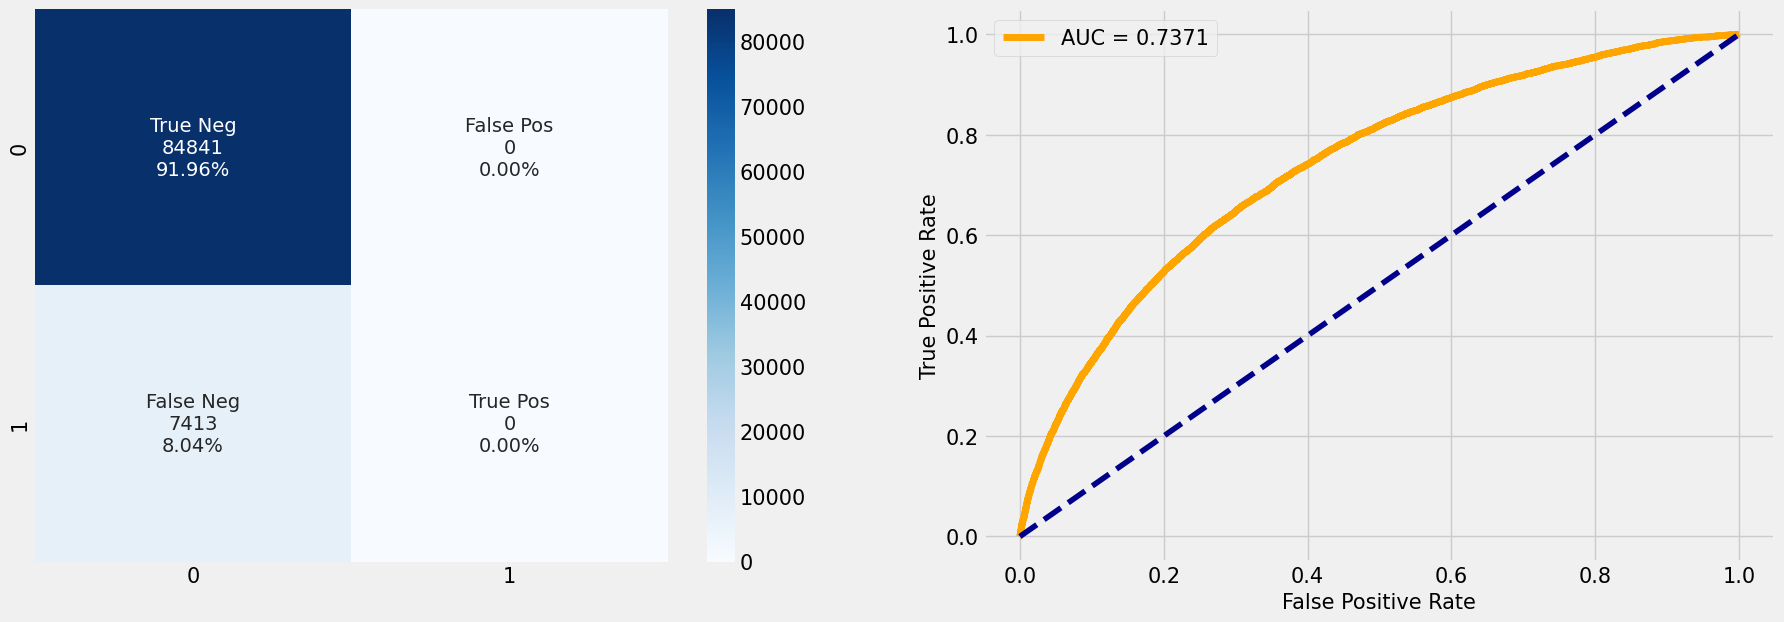

In [20]:
train_lr_model(0.001,100,final_data)


ElasticNet model (C=0.001000,max_iter=100.000000):
 RMSE: 0.28346823346289474
 MAE:0.0803542393825742
 R2:-0.08737520774154017
AUC : 0.7371
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



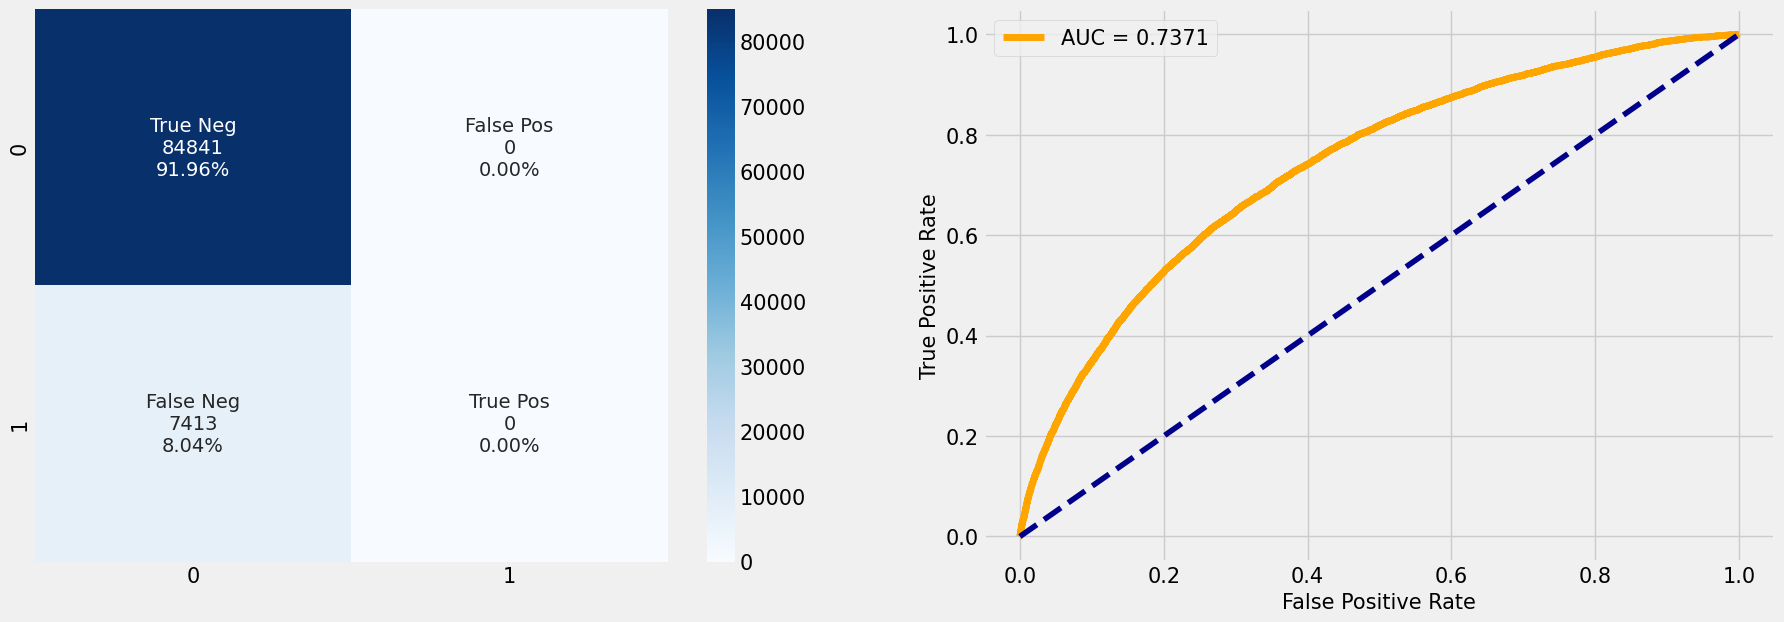

In [21]:
train_lr_model(0.001,100,final_data)

ElasticNet model (C=0.002000,max_iter=100.000000):
 RMSE: 0.2834873524885438
 MAE:0.08036507902096386
 R2:-0.08752189264748123
AUC : 0.7442
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.40      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.66      0.50      0.48     92254
weighted avg       0.88      0.92      0.88     92254



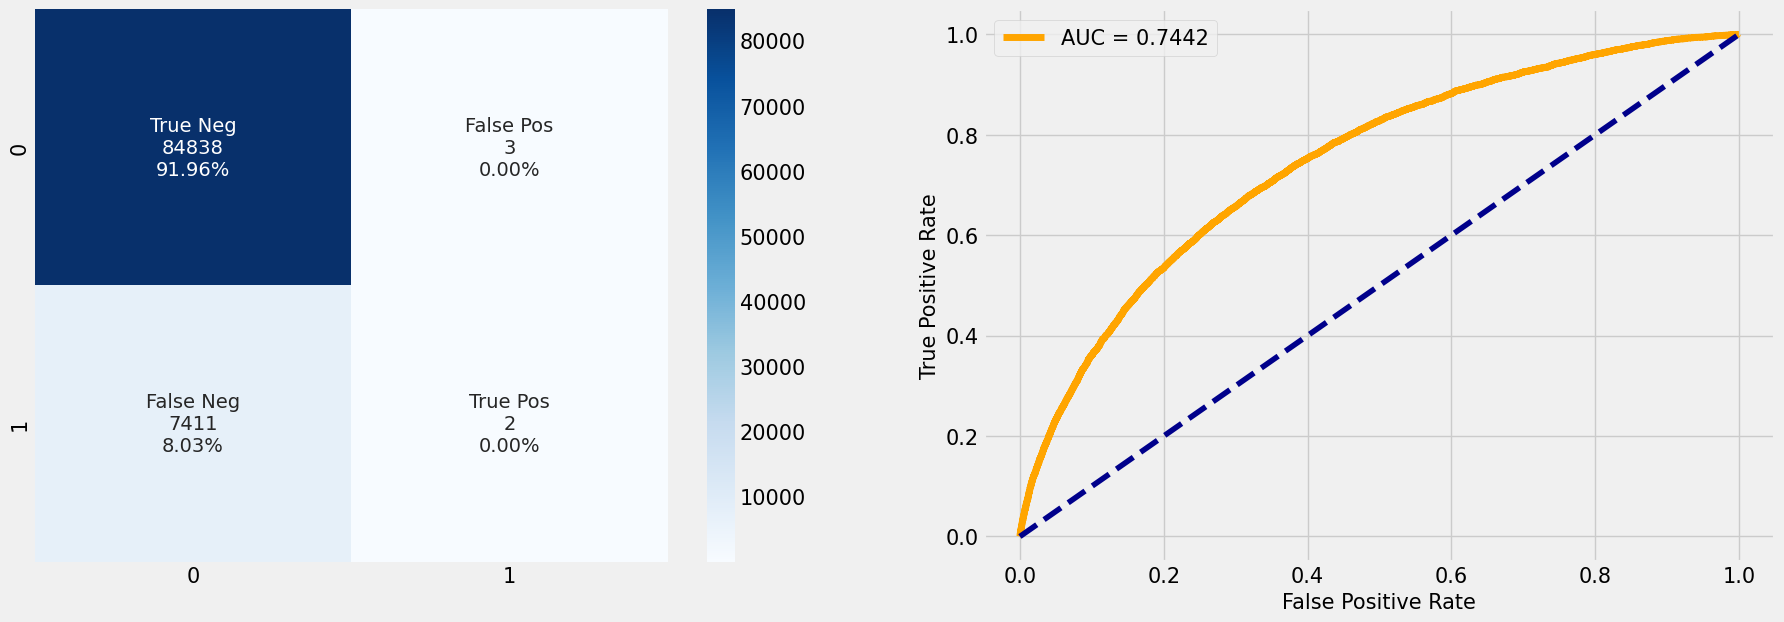

In [22]:
train_lr_model(0.002,100,final_data)

ElasticNet model (C=0.100000,max_iter=100.000000):
 RMSE: 0.2830472881657791
 MAE:0.0801157673380016
 R2:-0.08414813981083547
AUC : 0.7558
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.55      0.02      0.03      7413

    accuracy                           0.92     92254
   macro avg       0.74      0.51      0.49     92254
weighted avg       0.89      0.92      0.88     92254



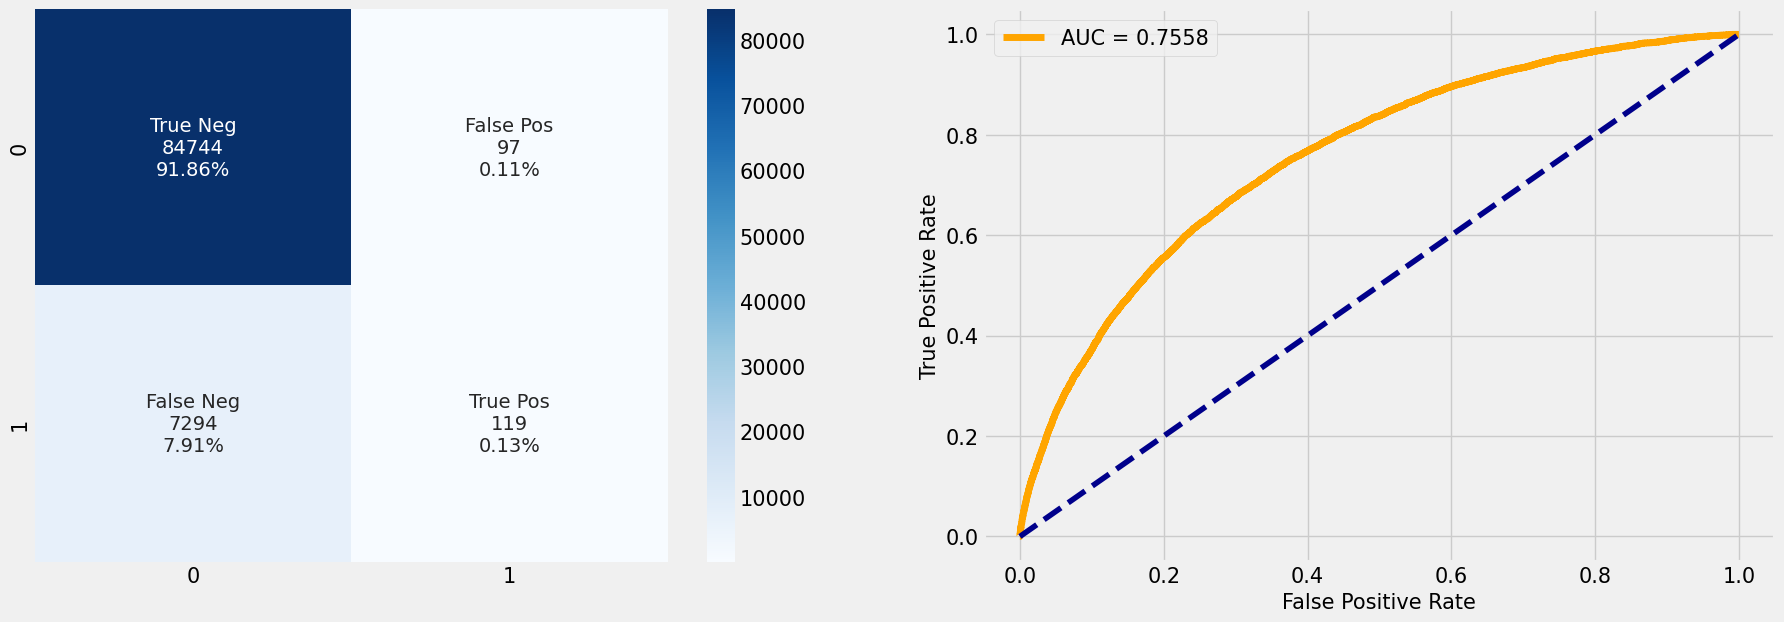

In [23]:
train_lr_model(0.1,100,final_data)

ElasticNet model (C=1.000000,max_iter=100.000000):
 RMSE: 0.2830855817854045
 MAE:0.08013744661478094
 R2:-0.08444150962271779
AUC : 0.7559
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.54      0.02      0.04      7413

    accuracy                           0.92     92254
   macro avg       0.73      0.51      0.50     92254
weighted avg       0.89      0.92      0.88     92254



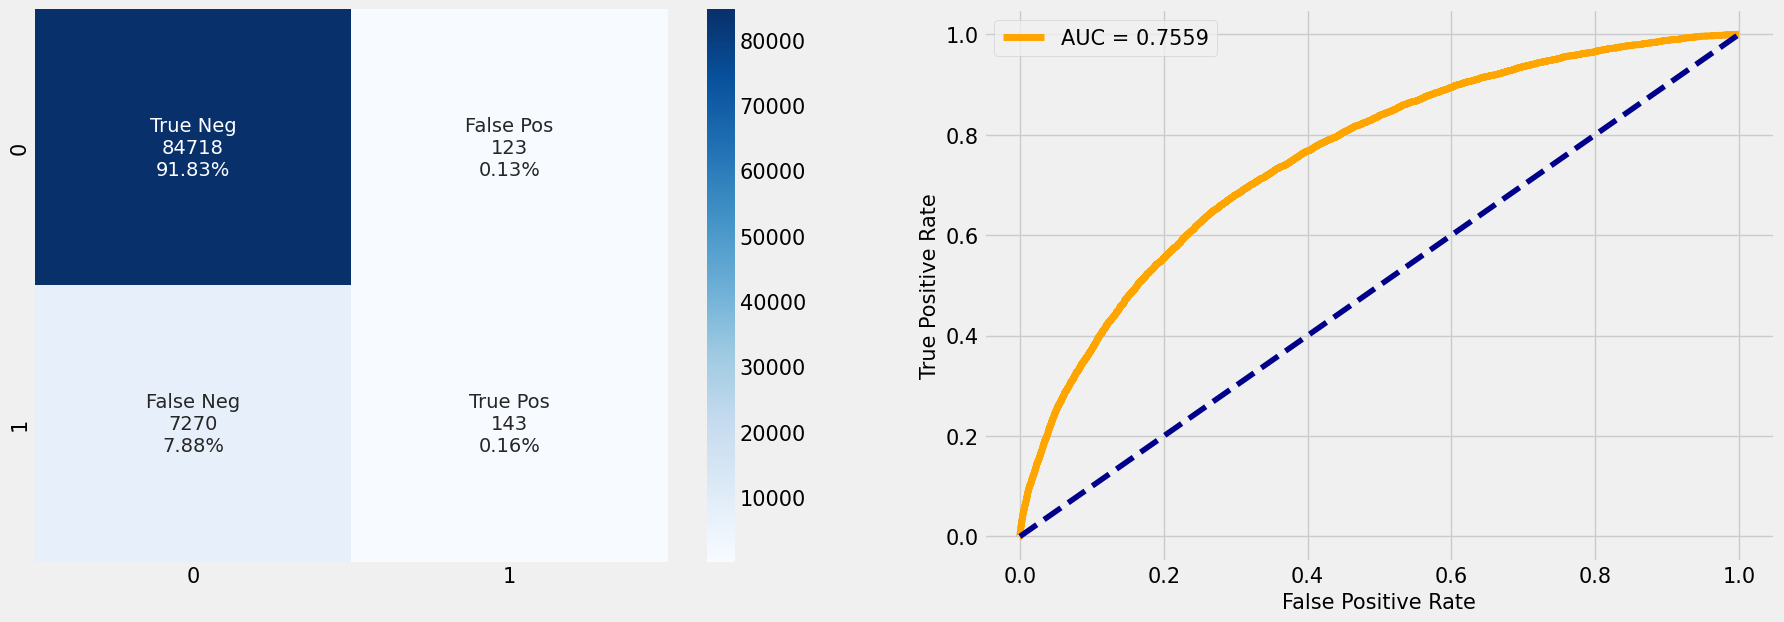

In [24]:
train_lr_model(1.0,100,final_data)

ElasticNet model (C=1.000000,max_iter=10000.000000):
 RMSE: 0.2832195686803943
 MAE:0.08021332408350858
 R2:-0.0854683039643056
AUC : 0.7578
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.52      0.02      0.04      7413

    accuracy                           0.92     92254
   macro avg       0.72      0.51      0.50     92254
weighted avg       0.89      0.92      0.88     92254



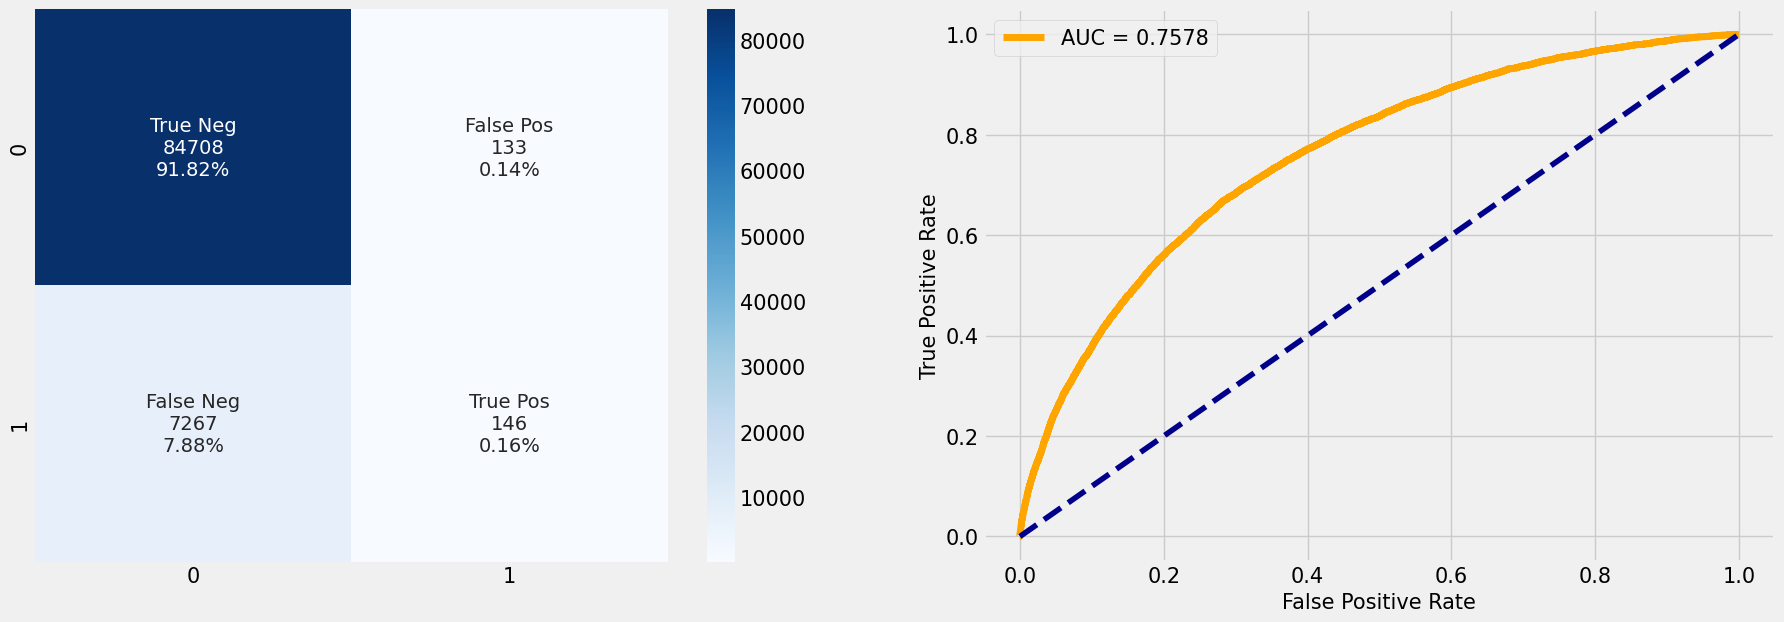

In [25]:
train_lr_model(1.0,10000,final_data)

In [26]:
mlflow.end_run()

In [27]:
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6943
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254



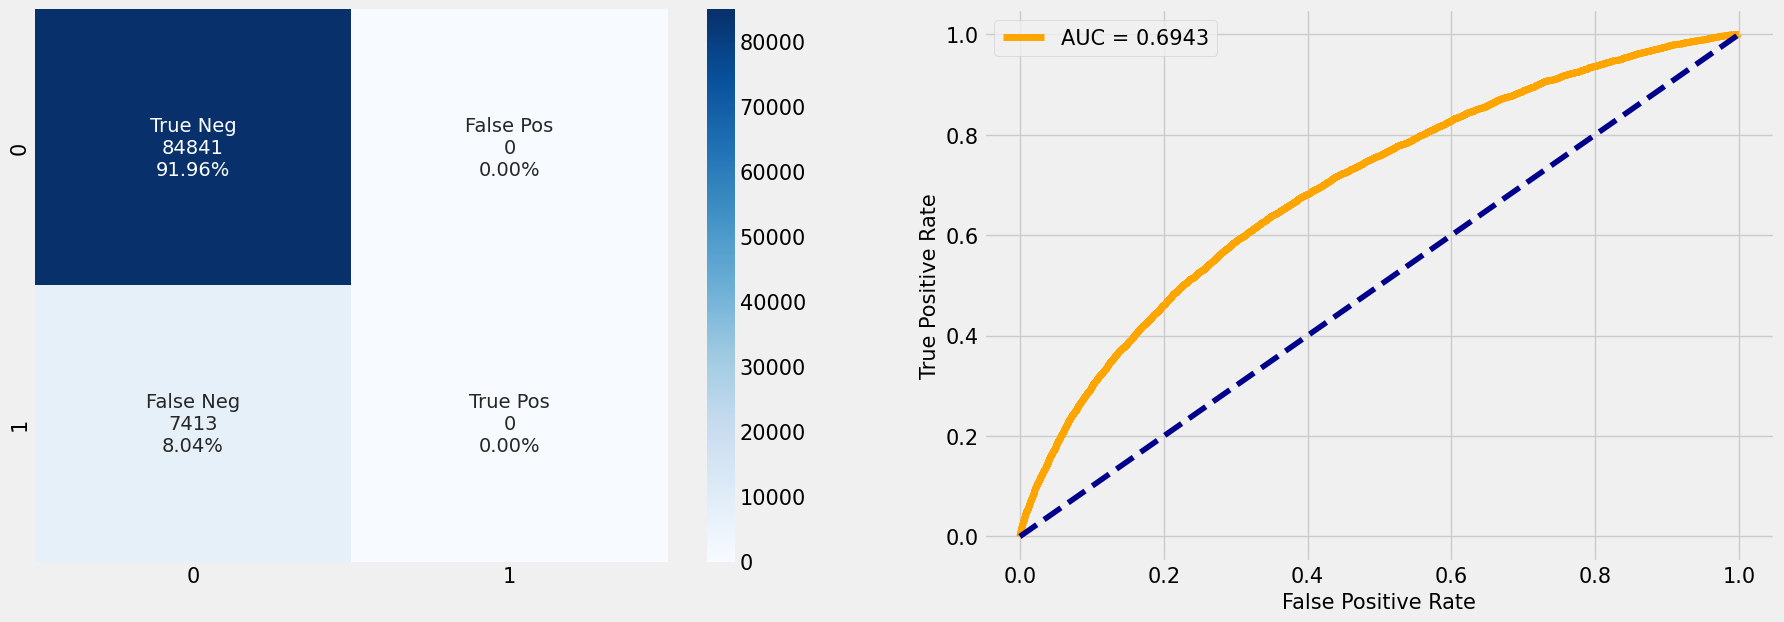

In [28]:
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)

### Conclusion

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 ( environ 0.92) et la Target 1 (0.08). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit.

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français) en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

# 4. Oversampling Data Using SMOTE
SMOTE with Imbalance Data using imblearn module

In [29]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [30]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17412 
Label 0, Before using SMOTE: 197845 


In [31]:
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [32]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


### Preparing SMOTE DATA

In [33]:
X_train_smote=X_train_res
y_train_smote=y_train_res

In [34]:
mlflow.set_experiment('Linear-Regression-SMOTE')

2023/11/05 11:10:05 INFO mlflow.tracking.fluent: Experiment with name 'Linear-Regression-SMOTE' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/450330512157598382', creation_time=1699179005285, experiment_id='450330512157598382', last_update_time=1699179005285, lifecycle_stage='active', name='Linear-Regression-SMOTE', tags={}>

In [35]:
#MLFLow Model function Linear Regression
def train_lr_model_smote(C,max_iter,data,X_train_smote,y_train_smote):
    train,test=train_test_split(data,test_size=0.3,random_state=42)
    
    #Predicted quality is from 3 to 9
    train_x=X_train_smote
    test_x=test.drop(["TARGET2"],axis=1)
    train_y=y_train_smote
    test_y=test[["TARGET2"]]
    
    
    with mlflow.start_run():
        
        lr = LogisticRegression(C=C,max_iter=max_iter)
        lr.fit(train_x,train_y)
        
        predicted_qualities=lr.predict(test_x)
        
        (rmse,mae,r2)=eval_metrics(test_y,predicted_qualities)
        print("ElasticNet model (C=%f,max_iter=%f):" % (C,max_iter))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        
        roc_auc = roc_auc_score(test_y, lr.predict_proba(test_x)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(test_y, lr.predict(test_x)))
        cf_matrix_roc_auc(lr, test_y, lr.predict(test_x), lr.predict_proba(test_x)[:,1], feature_importances=None,roc_auc=roc_auc)
        
        mlflow.log_param("C",C)
        mlflow.log_param("max_iter",max_iter)
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("AUC",roc_auc)
        
        mlflow.sklearn.log_model(lr,"model")

ElasticNet model (C=0.001000,max_iter=100.000000):
 RMSE: 0.5530577872876573
 MAE:0.3058729160795196
 R2:-3.1391546758465907
AUC : 0.7408
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     84841
         1.0       0.16      0.66      0.26      7413

    accuracy                           0.69     92254
   macro avg       0.56      0.68      0.53     92254
weighted avg       0.89      0.69      0.76     92254



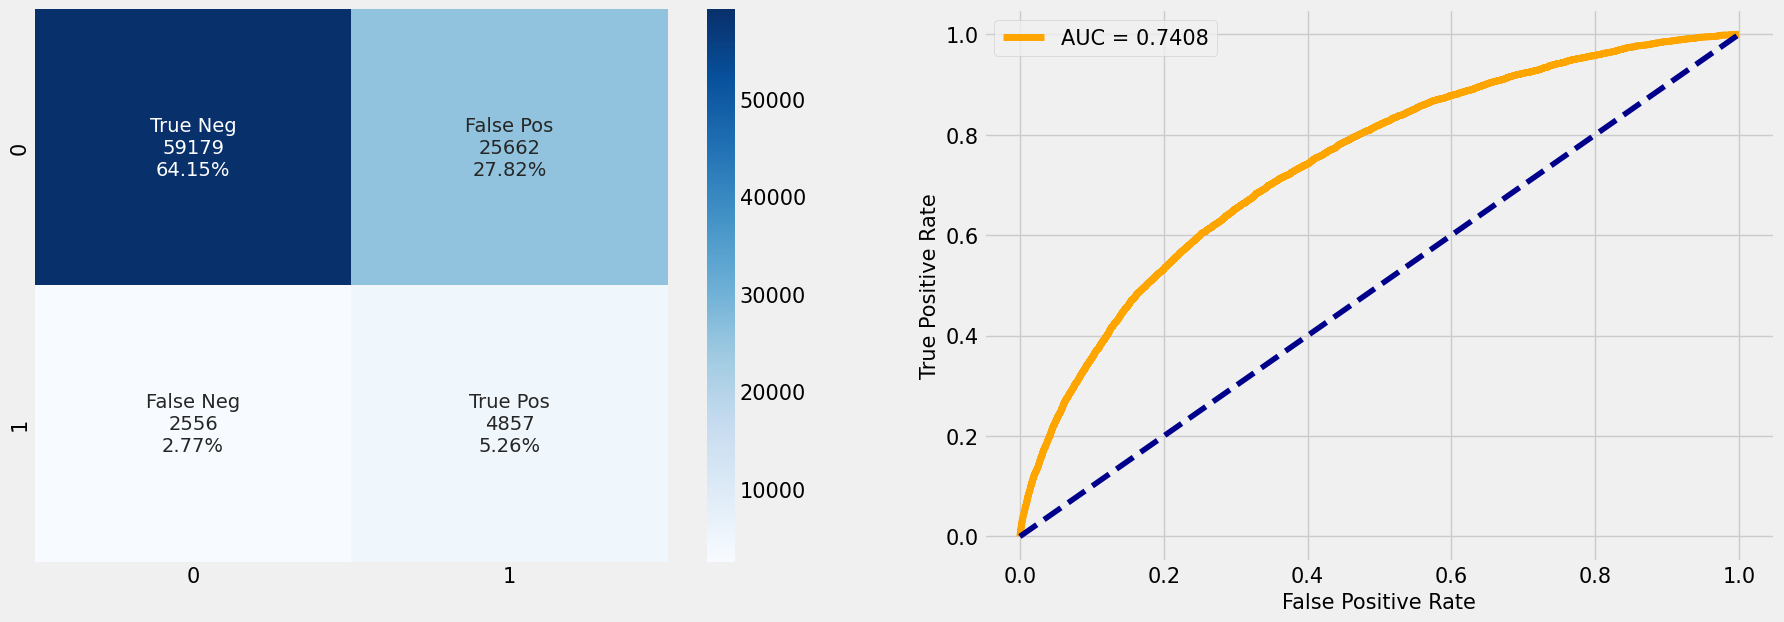

In [36]:
train_lr_model_smote(0.001,100,final_data,X_train_smote,y_train_smote)

ElasticNet model (C=1.000000,max_iter=100.000000):
 RMSE: 0.548294201226789
 MAE:0.30062653109892257
 R2:-3.0681591813710876
AUC : 0.7451
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     84841
         1.0       0.16      0.65      0.26      7413

    accuracy                           0.70     92254
   macro avg       0.56      0.68      0.54     92254
weighted avg       0.89      0.70      0.77     92254



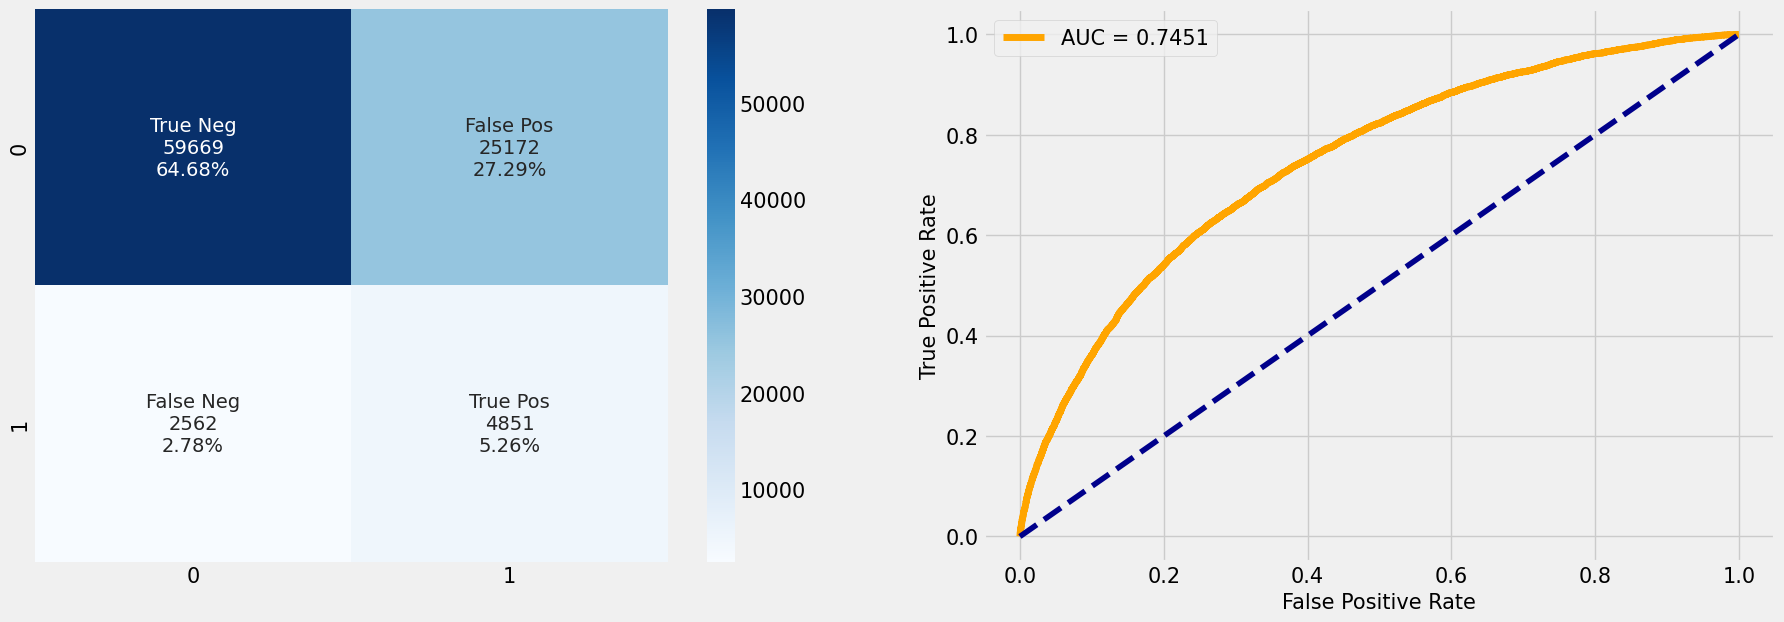

In [37]:
train_lr_model_smote(1.0,100,final_data,X_train_smote,y_train_smote)  

In [38]:
mlflow.end_run()

In [39]:
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7188
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.51     92254
weighted avg       0.89      0.67      0.74     92254



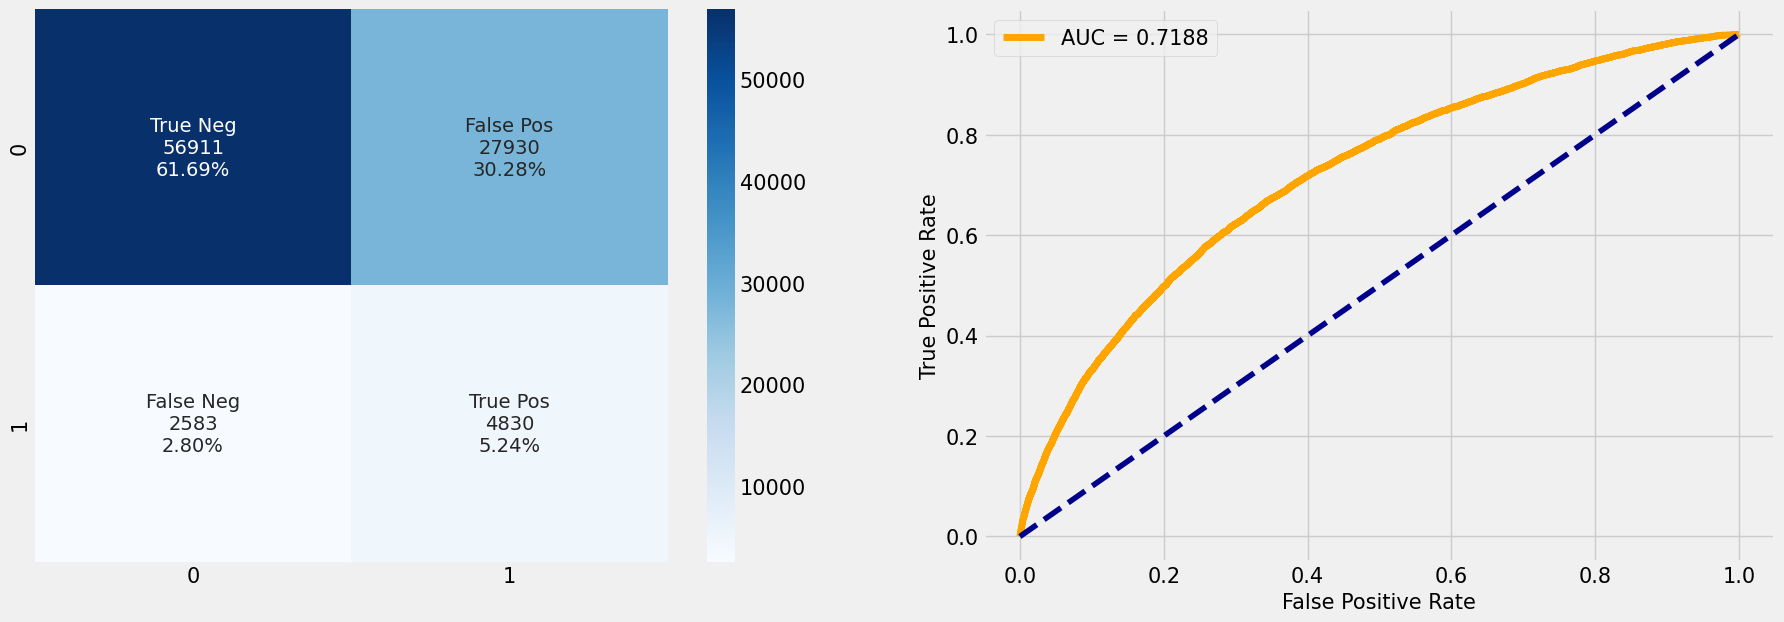

In [40]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)


Amélioration de l'AUC score 0.75 que nous prendrons comme baseline de travail pour la suite des essais. 

# 5. Gradient Boosting 

On utilisera les modèles : Catboost, Lightgbm et XGBoost en Classifier. 

In [41]:
!pip install catboost
!pip install lightgbm
!pip install xgboost



In [42]:
#Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [43]:
mlflow.set_experiment('Gradient-Boosting-models')

2023/11/05 11:10:48 INFO mlflow.tracking.fluent: Experiment with name 'Gradient-Boosting-models' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/310154478172674549', creation_time=1699179048183, experiment_id='310154478172674549', last_update_time=1699179048183, lifecycle_stage='active', name='Gradient-Boosting-models', tags={}>

## Données sans équilibrage

In [44]:
from sklearn import metrics

In [45]:
def train_model(model,data):
    train,test=train_test_split(data,test_size=0.3,random_state=42)
    
    #Predicted quality is from 3 to 9
    X_train=train.drop(["TARGET2"],axis=1)
    X_test=test.drop(["TARGET2"],axis=1)
    y_train=train[["TARGET2"]]
    y_test=test[["TARGET2"]]
    
    
    with mlflow.start_run():
        
        trained_model=model.fit(X_train, y_train)
        predicted_qualities=trained_model.predict(X_test)
    
        #Evaluation metrics
        (rmse,mae,r2)=eval_metrics(y_test,predicted_qualities)
        accuracy=accuracy_score(y_test, predicted_qualities)
        precision=precision_score(y_test,predicted_qualities)
        recall=recall_score(y_test,predicted_qualities)
        f_one=metrics.f1_score(y_test,predicted_qualities)
        
        #print("Model used:" % str(model))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        print(" Accuracy: %s" % accuracy)
        print(" Precision:%s" % precision)
        print(" Recall:%s" % recall)
        print(" F-1 Score: %s" % f_one)
       
        
        roc_auc = roc_auc_score(y_test, trained_model.predict_proba(X_test)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, trained_model.predict(X_test)))
        cf_matrix_roc_auc(model, y_test, trained_model.predict(X_test), trained_model.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)
        
     
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("accuracy",accuracy)
        mlflow.log_metric("precision",precision)
        mlflow.log_metric("recall",recall)
        mlflow.log_metric("F-1 score",f_one)
        mlflow.log_metric("AUC",roc_auc)
        
        mlflow.sklearn.log_model(model,"model")

 RMSE: 0.2826065385921553
 MAE:0.07986645565503935
 R2:-0.0807743869741897
 Accuracy: 0.9201335443449606
 Precision:0.5566750629722922
 Recall:0.029812491568865507
 F-1 Score: 0.056594110115236886
AUC : 0.7759
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.56      0.03      0.06      7413

    accuracy                           0.92     92254
   macro avg       0.74      0.51      0.51     92254
weighted avg       0.89      0.92      0.89     92254



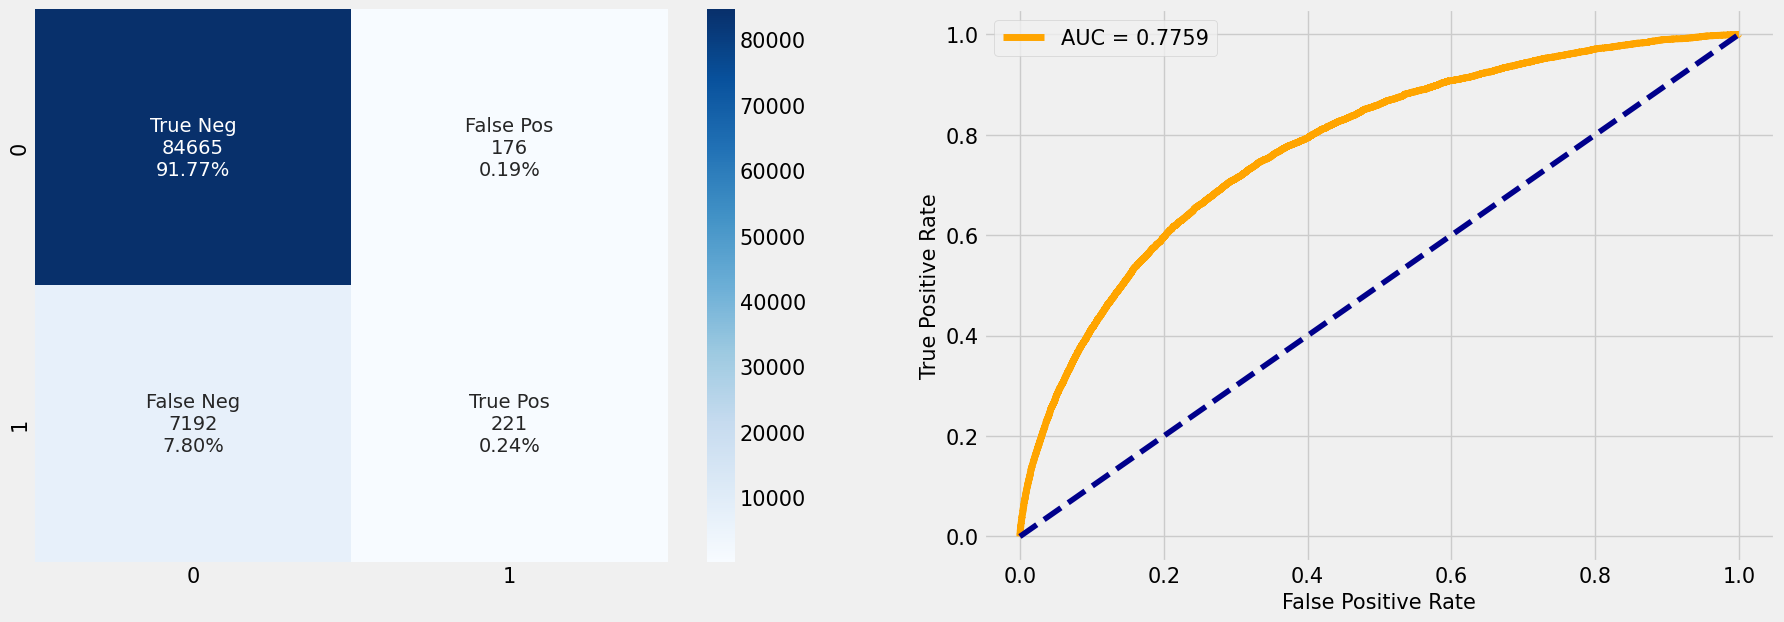

In [46]:
train_model(CatBoostClassifier(task_type="GPU", logging_level='Silent'),final_data)

In [47]:
import re
final_data_light=final_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 27720
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 304
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 101 dense feature groups (21.35 MB) transferred to GPU in 0.026414 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
 RMSE: 0.28293237620969364
 MAE:0.08005072950766362
 R2:-0.0832680303751887
 Accuracy: 0.9199492704923363
 Precision:0.5318181818181819
 Recall:0.03156616754350466
 F-1 Score: 0.05959505921303961
AUC : 0.7738
              precision    recall  f1-s

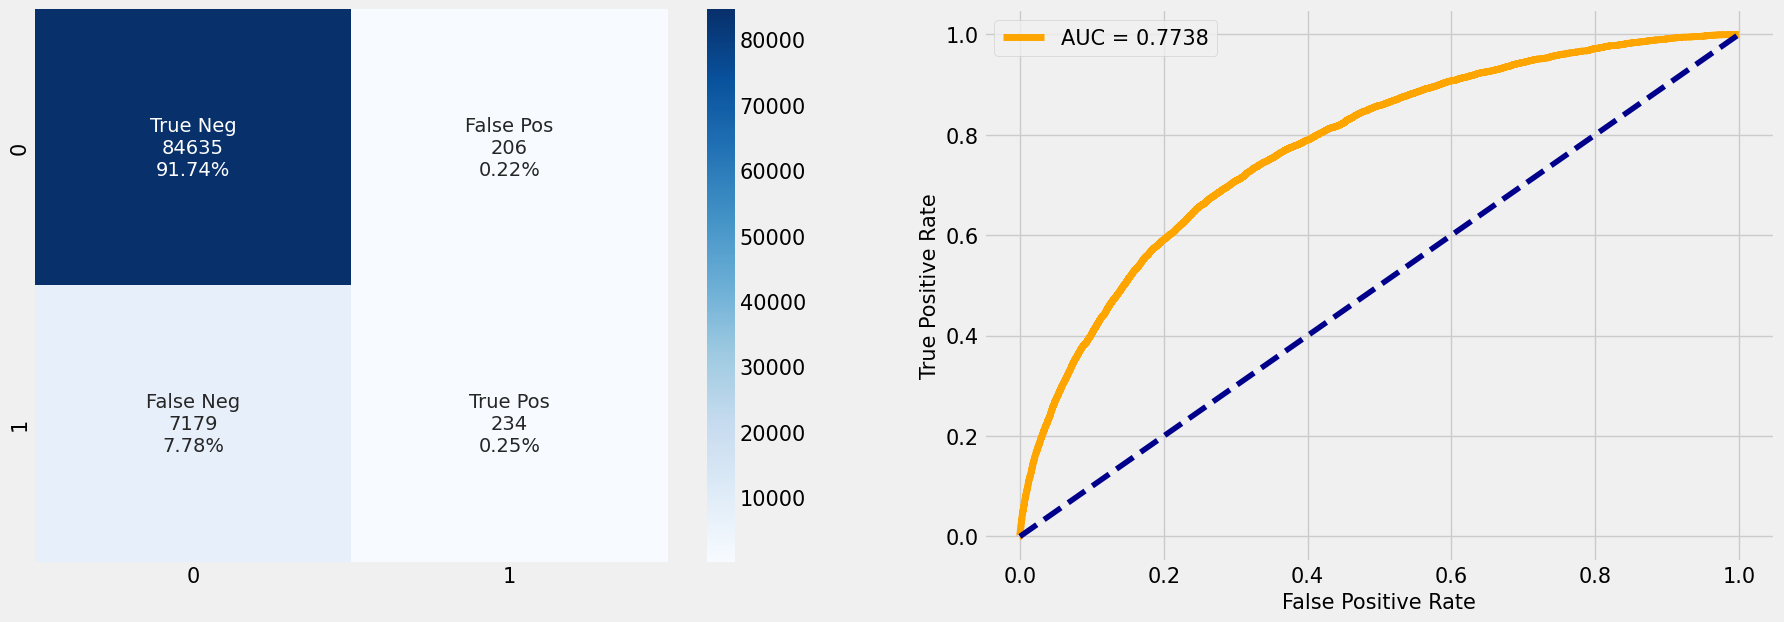

In [48]:
light_boost=LGBMClassifier(device='gpu')
train_model(light_boost,final_data_light)

 RMSE: 0.28455596773004954
 MAE:0.08097209877078501
 R2:-0.09573624738018416
 Accuracy: 0.919027901229215
 Precision:0.46871569703622395
 Recall:0.05760151085930123
 F-1 Score: 0.10259490629505046
AUC : 0.7678
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.47      0.06      0.10      7413

    accuracy                           0.92     92254
   macro avg       0.70      0.53      0.53     92254
weighted avg       0.89      0.92      0.89     92254



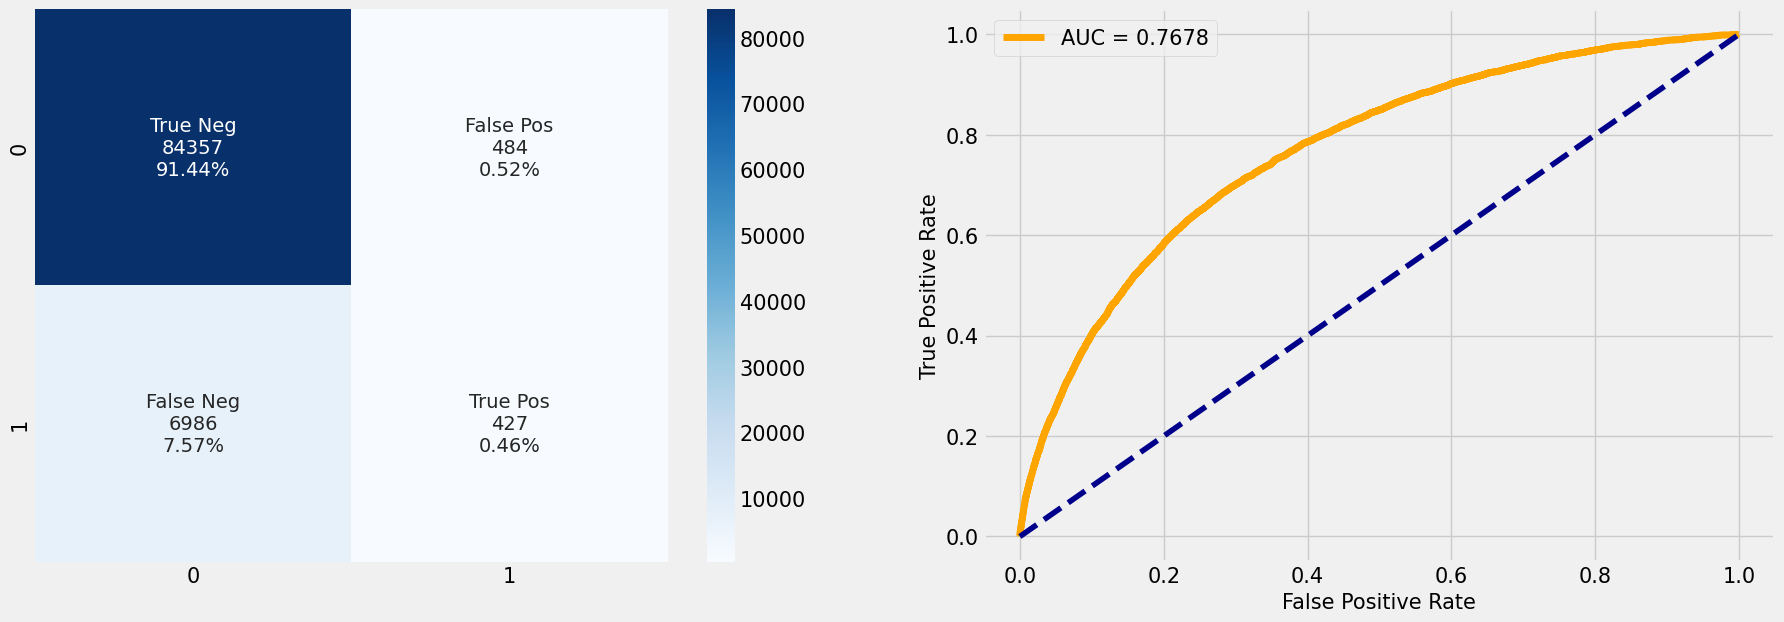

In [49]:
train_model(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'),final_data)

### Showing results here

In [50]:
models = [
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')]

La fonction suivante train_models peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux Scoring de Classification de Scikit-learn.

In [51]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': metrics.f1_score(y_test, model.predict(X_test),average='weighted')
      }

    return output

In [52]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    final_data_light=final_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    train,test=train_test_split(final_data_light,test_size=0.3,random_state=42)
    
    #Predicted quality is from 3 to 9
    X_train=train.drop(["TARGET2"],axis=1)
    X_test=test.drop(["TARGET2"],axis=1)
    y_train=train[["TARGET2"]]
    y_test=test[["TARGET2"]]
    
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 27720
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 304
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 101 dense feature groups (21.35 MB) transferred to GPU in 0.033210 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
CPU times: total: 1min 17s
Wall time: 33.1 s


In [53]:
base_models

Model       AUC  Accuracy Precision    Recall        F1  \
0  CatBoostClassifier  0.775686  0.920134  0.557545  0.029408  0.885789   
1      LGBMClassifier   0.77383  0.919938  0.530752  0.031431  0.885964   
2       XGBClassifier  0.767821  0.919028  0.468716  0.057602  0.888898   

        Time  
0  16.626712  
1   8.150296  
2   8.317688

Le LightGBM et Le Catboost ont un AUC plus élevé de 0.77. Cependant le Lightboost est beaucoup plus rapide. 

### Performance des algorithmes avec scale_pos_weight pour l'équilibrage des données 

lien : https://www.kaggle.com/code/kaanboke/xgboost-lightgbm-catboost-imbalanced-data

 RMSE: 0.30546293925486584
 MAE:0.09330760725822186
 R2:-0.2626636703411813
 Accuracy: 0.9066923927417782
 Precision:0.3629901398761752
 Recall:0.21354377445029002
 F-1 Score: 0.268897570918974
AUC : 0.7773
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     84841
         1.0       0.36      0.21      0.27      7413

    accuracy                           0.91     92254
   macro avg       0.65      0.59      0.61     92254
weighted avg       0.89      0.91      0.90     92254



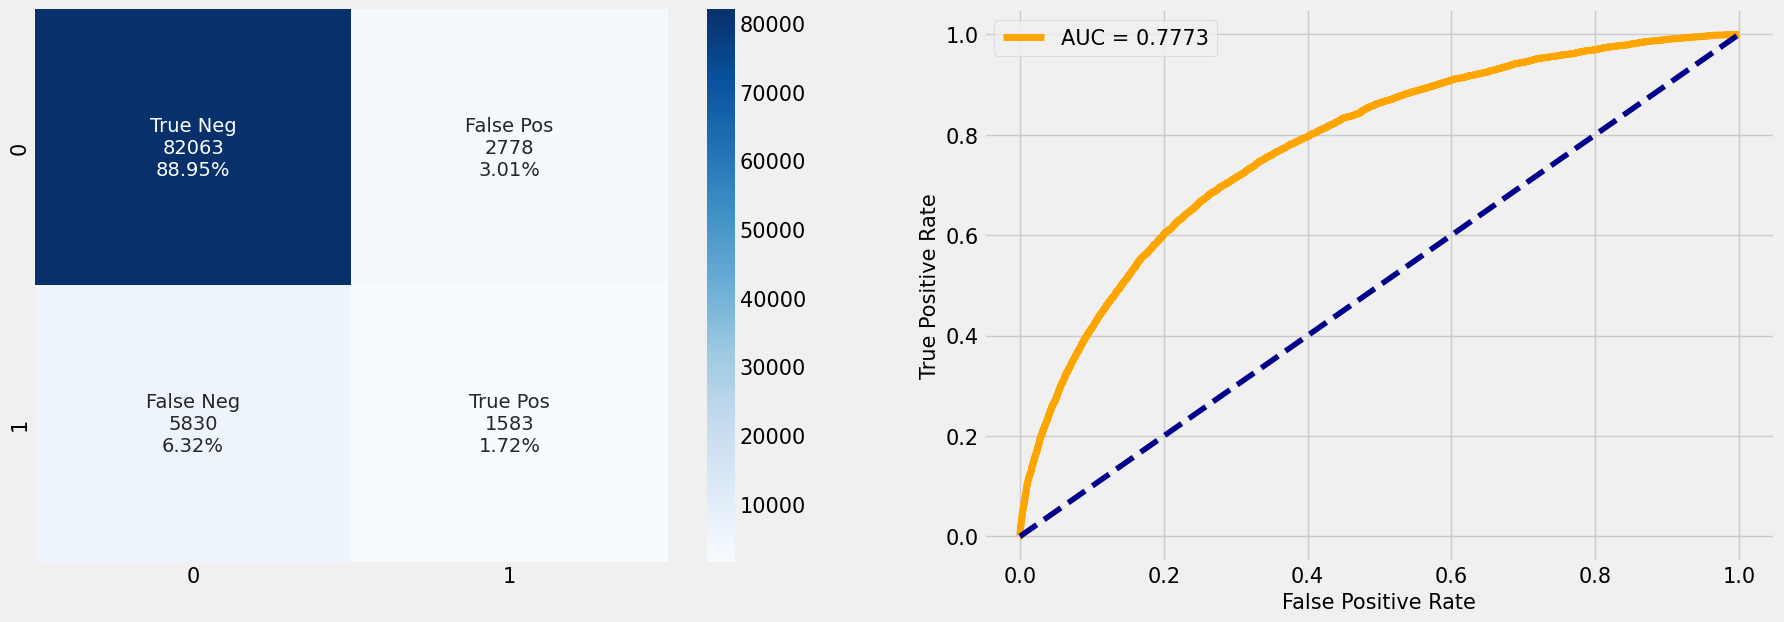

In [54]:
#Catboost with scale_pos_weight 3
train_model(CatBoostClassifier(task_type="GPU", logging_level='Silent',scale_pos_weight=3),final_data)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 27720
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 304
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 101 dense feature groups (21.35 MB) transferred to GPU in 0.027055 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
 RMSE: 0.30813047991891523
 MAE:0.09494439265506102
 R2:-0.2848130911382909
 Accuracy: 0.905055607344939
 Precision:0.3543290043290043
 Recall:0.22082827465263727
 F-1 Score: 0.27208509931023017
AUC : 0.7761
              precision    recall  f1-sc

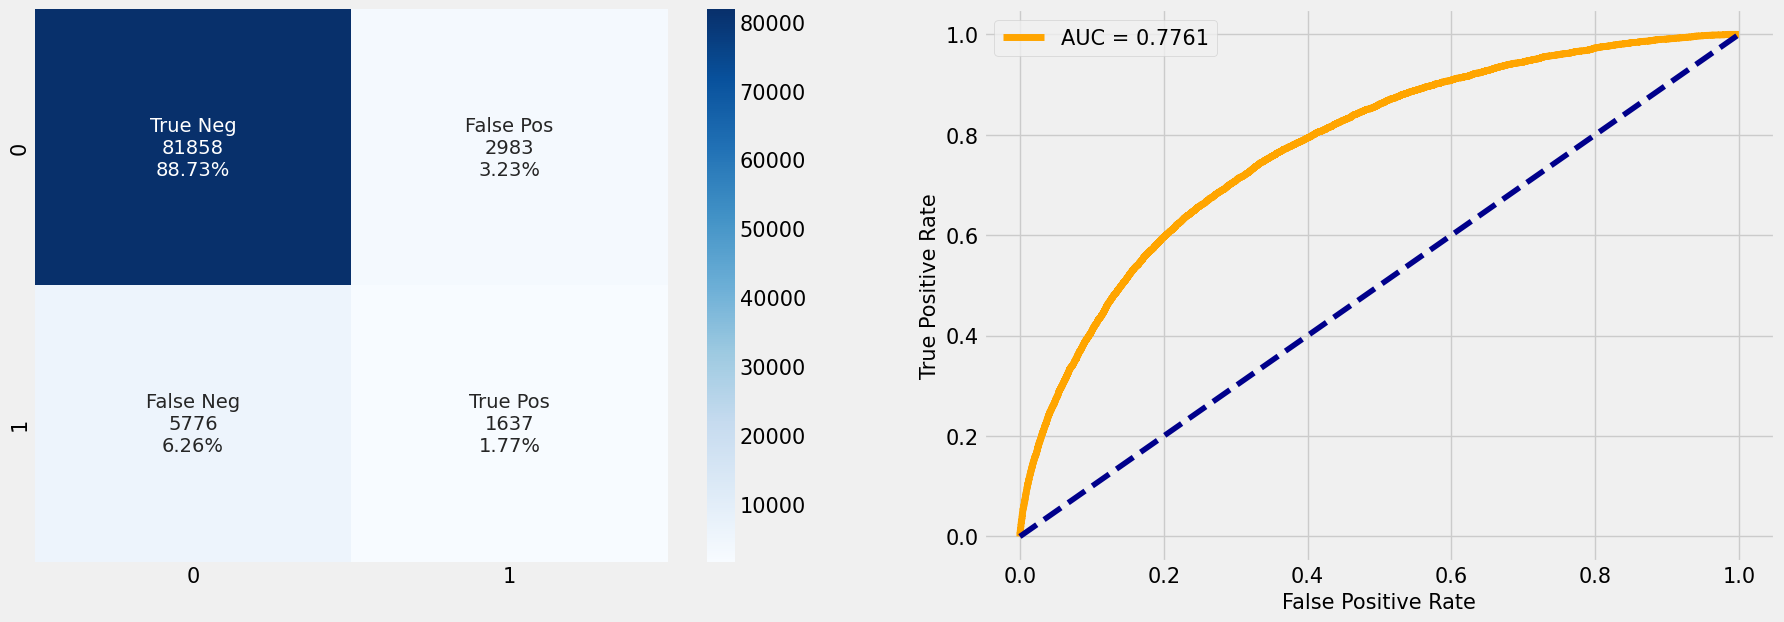

In [55]:
#LBoost with scale_pos_weight_3
light_boost=LGBMClassifier(device='gpu',scale_pos_weight=3)
train_model(light_boost,final_data_light)

 RMSE: 0.314122950866544
 MAE:0.09867322826110521
 R2:-0.3352726987820369
 Accuracy: 0.9013267717388947
 Precision:0.3329379201265322
 Recall:0.22716848779171725
 F-1 Score: 0.2700665544062224
AUC : 0.7661
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.95     84841
         1.0       0.33      0.23      0.27      7413

    accuracy                           0.90     92254
   macro avg       0.63      0.59      0.61     92254
weighted avg       0.89      0.90      0.89     92254



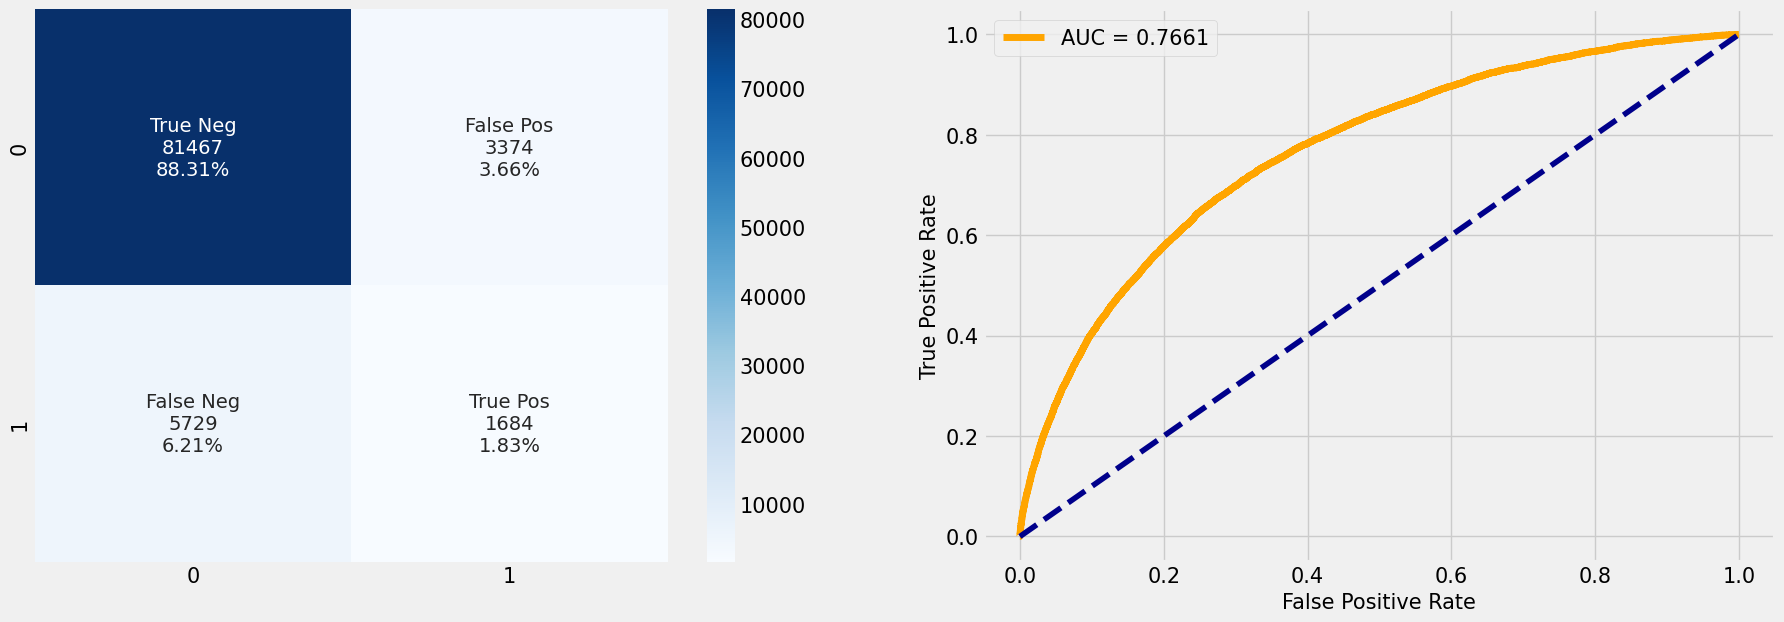

In [56]:
# XGBClassifier scale pos weight 3
train_model(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',scale_pos_weight=3),final_data)

 RMSE: 0.3576267514597272
 MAE:0.12789689335963753
 R2:-0.7307352051993028
 Accuracy: 0.8721031066403625
 Precision:0.28174761146496813
 Recall:0.3818966680156482
 F-1 Score: 0.32426550598476606
AUC : 0.7777
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93     84841
         1.0       0.28      0.38      0.32      7413

    accuracy                           0.87     92254
   macro avg       0.61      0.65      0.63     92254
weighted avg       0.89      0.87      0.88     92254



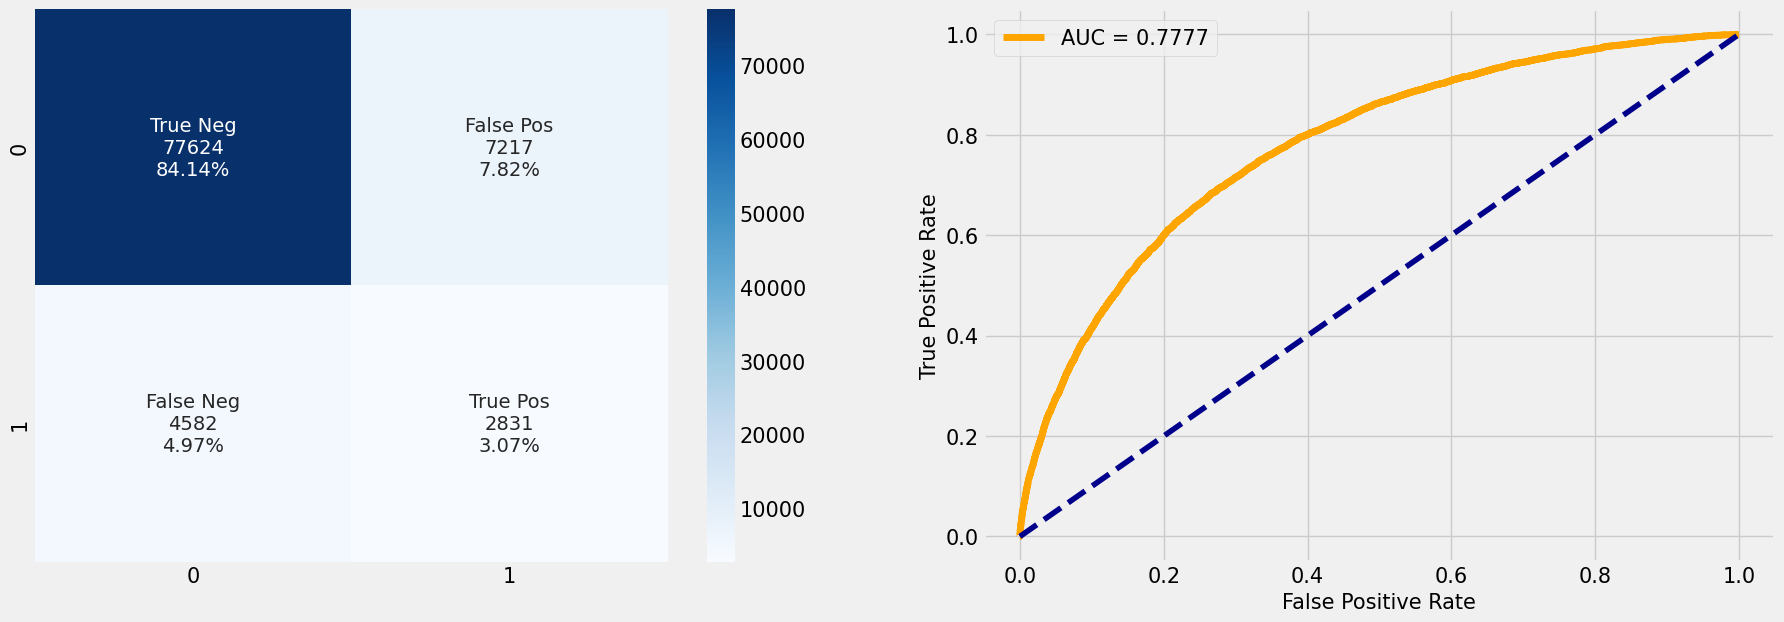

In [57]:
#Catboost with scale_pos_weight 5
train_model(CatBoostClassifier(task_type="GPU", logging_level='Silent',scale_pos_weight=5),final_data)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 27720
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 304
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 101 dense feature groups (21.35 MB) transferred to GPU in 0.019787 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
 RMSE: 0.36727164350242225
 MAE:0.13488846012097036
 R2:-0.8253469695313269
 Accuracy: 0.8651115398790297
 Precision:0.2688596894238721
 Recall:0.3947119924457035
 F-1 Score: 0.31985133362483603
AUC : 0.7762
              precision    recall  f1-sc

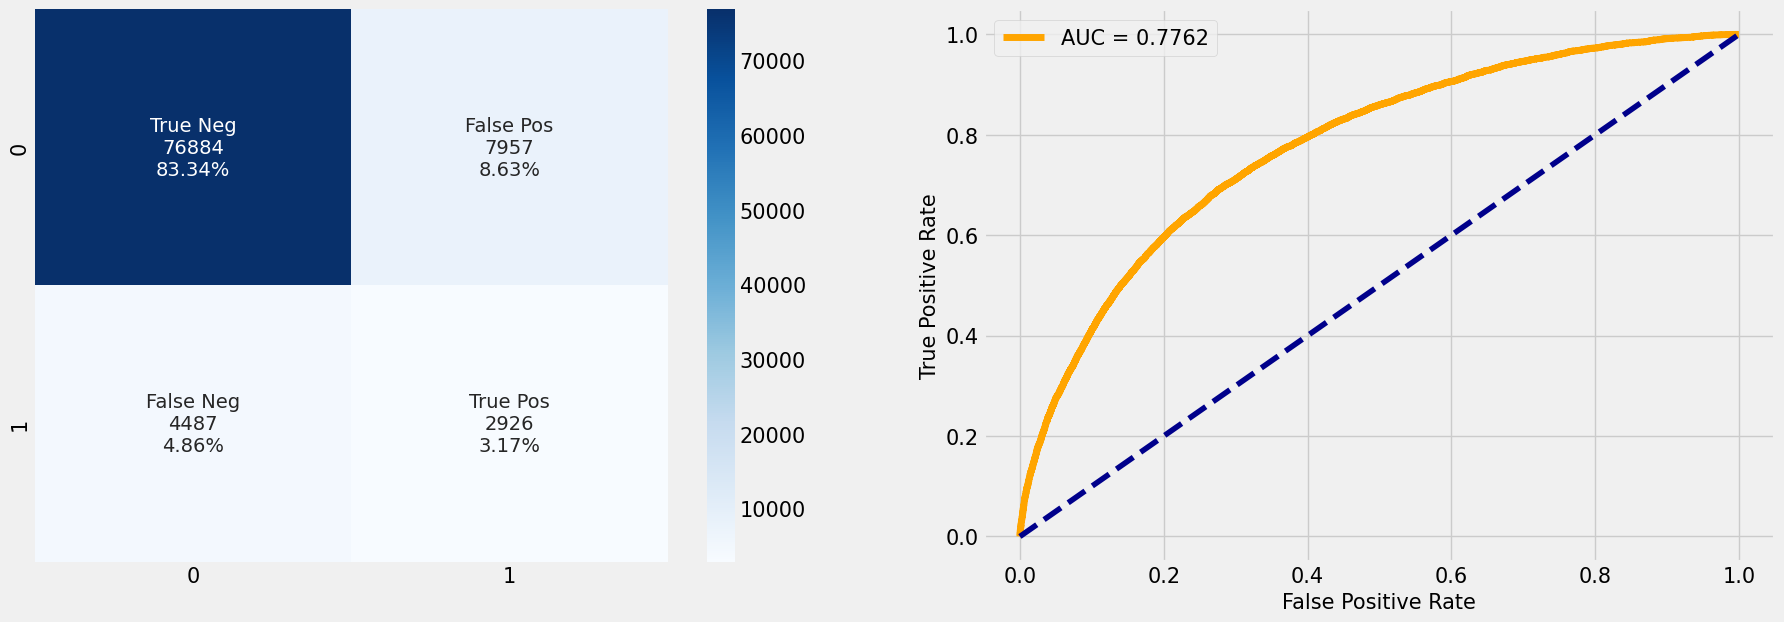

In [58]:
#LBoost with scale_pos_weight_5
light_boost=LGBMClassifier(device='gpu',scale_pos_weight=5)
train_model(light_boost,final_data_light)

 RMSE: 0.36091541187456117
 MAE:0.13025993452858411
 R2:-0.7627125146944675
 Accuracy: 0.8697400654714159
 Precision:0.26836385590662104
 Recall:0.3597733711048159
 F-1 Score: 0.30741743991700765
AUC : 0.7642
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.93     84841
         1.0       0.27      0.36      0.31      7413

    accuracy                           0.87     92254
   macro avg       0.61      0.64      0.62     92254
weighted avg       0.89      0.87      0.88     92254



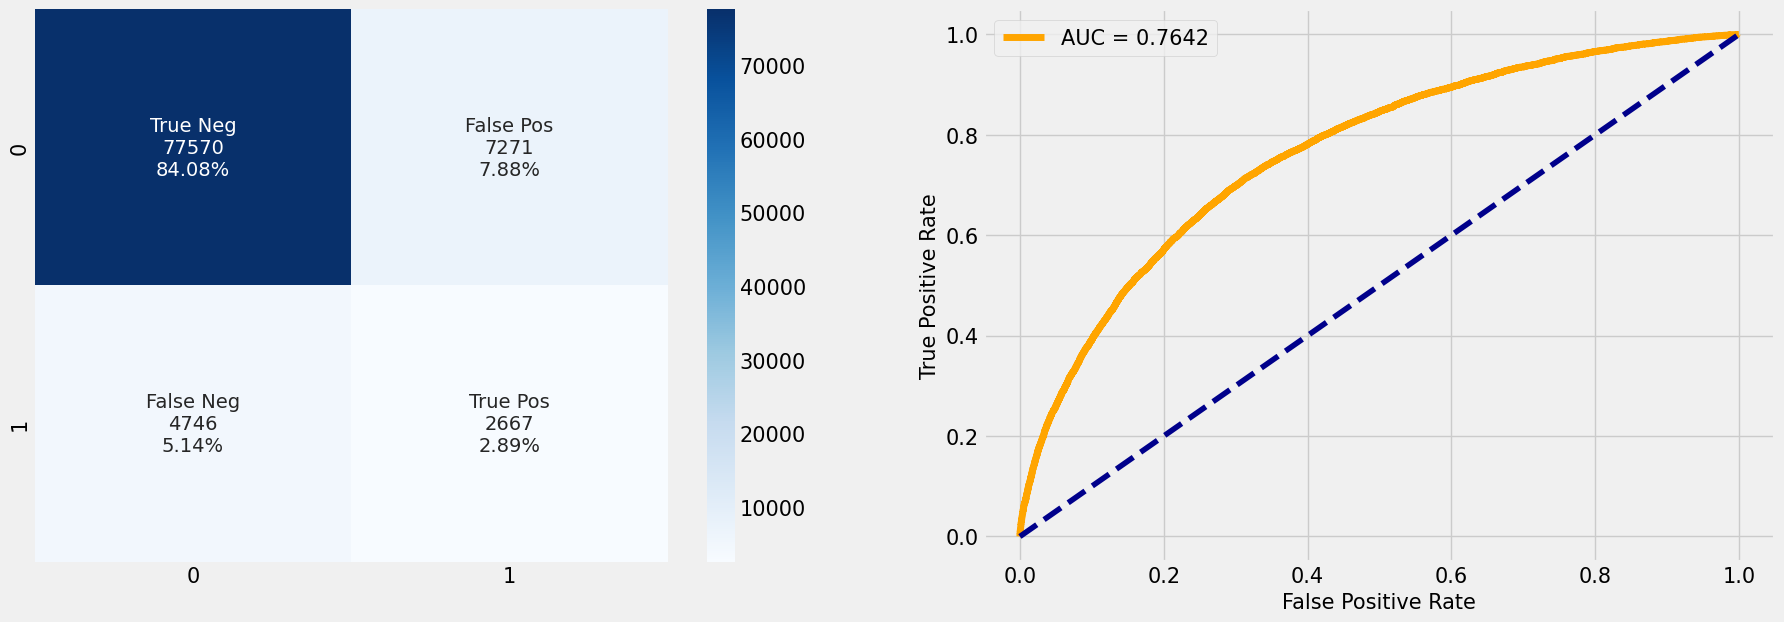

In [59]:
# XGBClassifier scale pos weight 5
train_model(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',scale_pos_weight=5),final_data)

In [60]:
#Présentation des résultats
models_scale_pos_weight = [
          CatBoostClassifier(task_type="GPU", logging_level='Silent',scale_pos_weight=3),
          LGBMClassifier(device='gpu',scale_pos_weight=3),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',scale_pos_weight=3),
          CatBoostClassifier(task_type="GPU", logging_level='Silent',scale_pos_weight=5),
          LGBMClassifier(device='gpu',scale_pos_weight=5),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',scale_pos_weight=5)
        ]

In [61]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models_scale_pos_weight:
    start = time.time()
    final_data_light=final_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    train,test=train_test_split(final_data_light,test_size=0.3,random_state=42)
    
    #Predicted quality is from 3 to 9
    X_train=train.drop(["TARGET2"],axis=1)
    X_test=test.drop(["TARGET2"],axis=1)
    y_train=train[["TARGET2"]]
    y_test=test[["TARGET2"]]
    
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 27720
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 304
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 101 dense feature groups (21.35 MB) transferred to GPU in 0.026103 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 27720
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 304
[L

In [62]:
base_models

Model       AUC  Accuracy Precision    Recall        F1  \
3  CatBoostClassifier  0.777736  0.872103  0.281574  0.381357  0.880723   
0  CatBoostClassifier  0.777334    0.9064  0.359605  0.211116  0.895053   
4      LGBMClassifier  0.776248  0.865112   0.26886  0.394712  0.876495   
1      LGBMClassifier  0.776074  0.905056  0.354329  0.220828  0.894806   
2       XGBClassifier  0.766147  0.901327  0.332938  0.227168  0.892686   
5       XGBClassifier  0.764202   0.86974  0.268364  0.359773  0.878234   

        Time  
3  16.487726  
0  18.187385  
4   8.286599  
1   8.055424  
2   8.405298  
5   8.220145

### Vérification des base models avec les données SMOTE : 

In [63]:
def train_model_smote(model,data,X_train_smote,y_train_smote):
    train,test=train_test_split(data,test_size=0.3,random_state=42)
    
    #train and test
    X_train=X_train_smote
    X_test=test.drop(["TARGET2"],axis=1)
    y_train=y_train_smote
    y_test=test[["TARGET2"]]
    
    
    with mlflow.start_run():
        
        trained_model=model.fit(X_train, y_train)
        predicted_qualities=trained_model.predict(X_test)
    
        #Evaluation metrics
        (rmse,mae,r2)=eval_metrics(y_test,predicted_qualities)
        accuracy=accuracy_score(y_test, predicted_qualities)
        precision=precision_score(y_test,predicted_qualities)
        recall=recall_score(y_test,predicted_qualities)
        f_one=metrics.f1_score(y_test,predicted_qualities,average='weighted')
        
        #print("Model used:" % str(model))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        print(" Accuracy: %s" % accuracy)
        print(" Precision:%s" % precision)
        print(" Recall:%s" % recall)
        print(" F-1 Score: %s" % f_one)
       
        
        roc_auc = roc_auc_score(y_test, trained_model.predict_proba(X_test)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, trained_model.predict(X_test)))
        cf_matrix_roc_auc(model, y_test, trained_model.predict(X_test), trained_model.predict_proba(X_test)[:,1], feature_importances=None,roc_auc=roc_auc)
        
     
        mlflow.log_metric("rmse",rmse)
        mlflow.log_metric("r2",r2)
        mlflow.log_metric("mae",mae)
        mlflow.log_metric("accuracy",accuracy)
        mlflow.log_metric("precision",precision)
        mlflow.log_metric("recall",recall)
        mlflow.log_metric("F-1 score",f_one)
        mlflow.log_metric("AUC",roc_auc)
        
        mlflow.sklearn.log_model(model,"model")

 RMSE: 0.2832195686803943
 MAE:0.08021332408350858
 R2:-0.0854683039643056
 Accuracy: 0.9197866759164914
 Precision:0.5168831168831168
 Recall:0.02684473222716849
 F-1 Score: 0.8852353739029785
AUC : 0.7638
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.52      0.03      0.05      7413

    accuracy                           0.92     92254
   macro avg       0.72      0.51      0.50     92254
weighted avg       0.89      0.92      0.89     92254



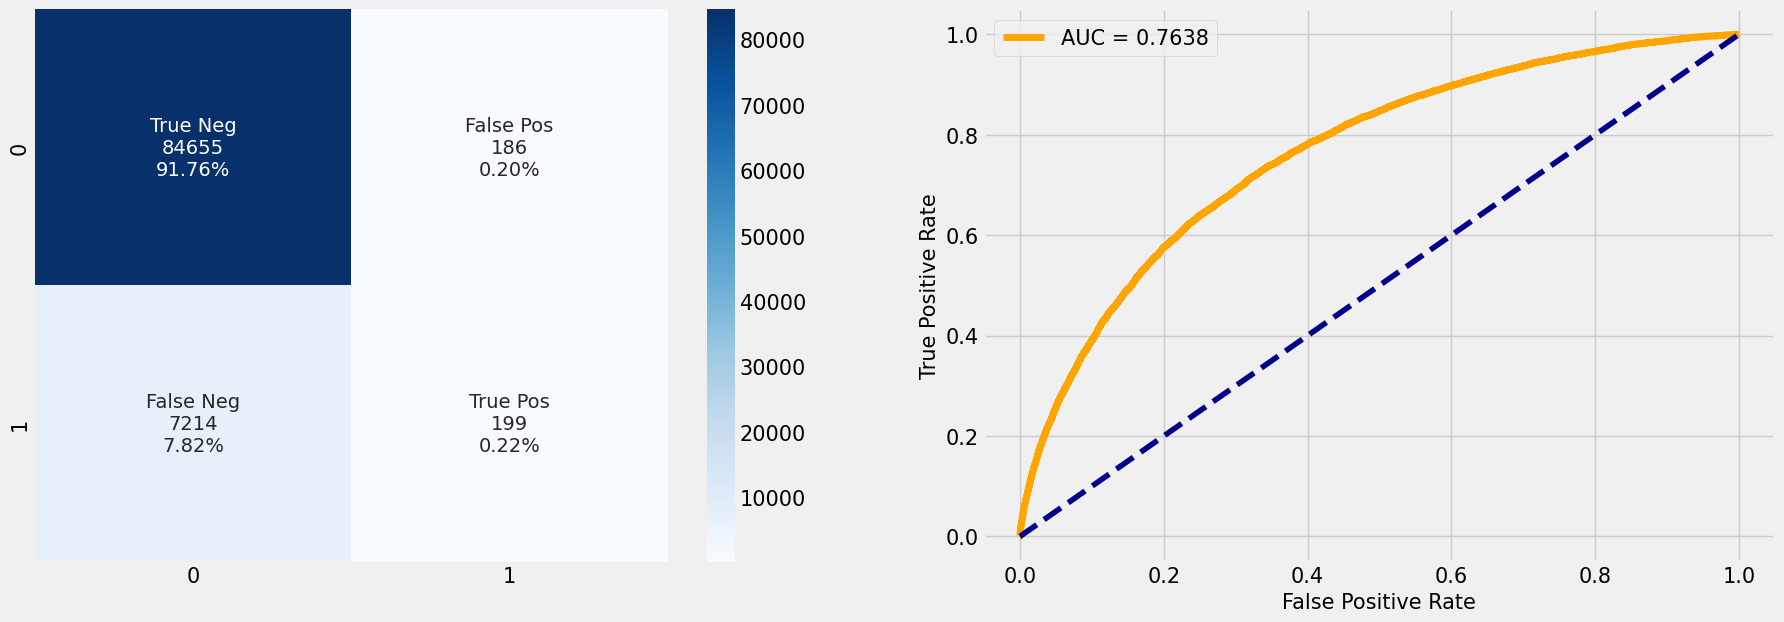

In [64]:
train_model_smote(CatBoostClassifier(task_type="GPU", logging_level='Silent'),final_data,X_train_smote,y_train_smote)

[LightGBM] [Info] Number of positive: 197845, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 68478
[LightGBM] [Info] Number of data points in the train set: 395690, number of used features: 306
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 115 dense feature groups (43.77 MB) transferred to GPU in 0.034998 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
 RMSE: 0.28421292243628027
 MAE:0.08077698527977106
 R2:-0.09309591907324388
 Accuracy: 0.9192230147202289
 Precision:0.4421364985163205
 Recall:0.020099824632402535
 F-1 Score: 0.8839638556481807
AUC : 0.7529
              precision    recall  f1-score   support

         0.0       0.92      1.00    

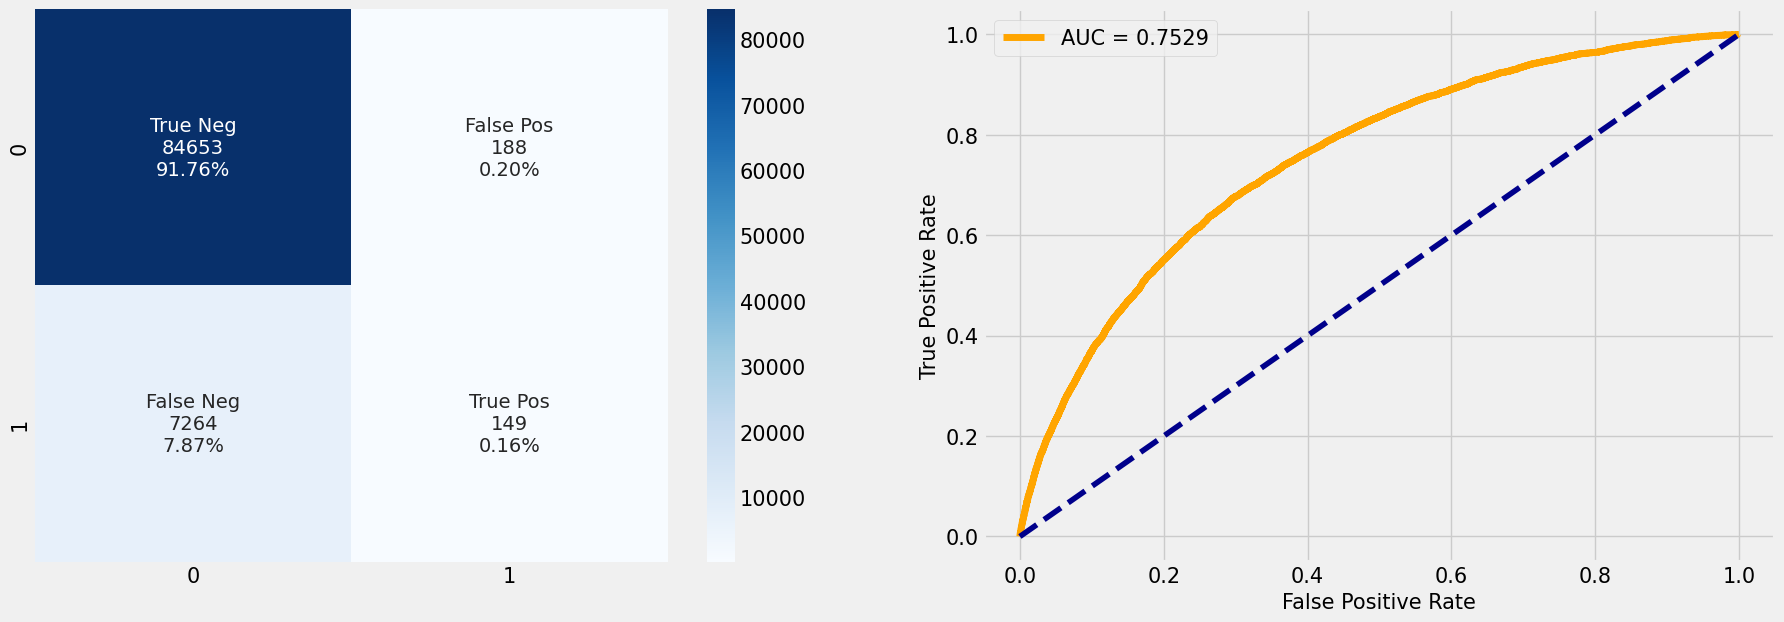

In [65]:
light_boost=LGBMClassifier(device='gpu')
train_model_smote(light_boost,final_data_light,X_train_smote,y_train_smote)

 RMSE: 0.2858102778146769
 MAE:0.08168751490450278
 R2:-0.10541745117229828
 Accuracy: 0.9183124850954972
 Precision:0.43322475570032576
 Recall:0.053824362606232294
 F-1 Score: 0.888001199303183
AUC : 0.7536
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.43      0.05      0.10      7413

    accuracy                           0.92     92254
   macro avg       0.68      0.52      0.53     92254
weighted avg       0.88      0.92      0.89     92254



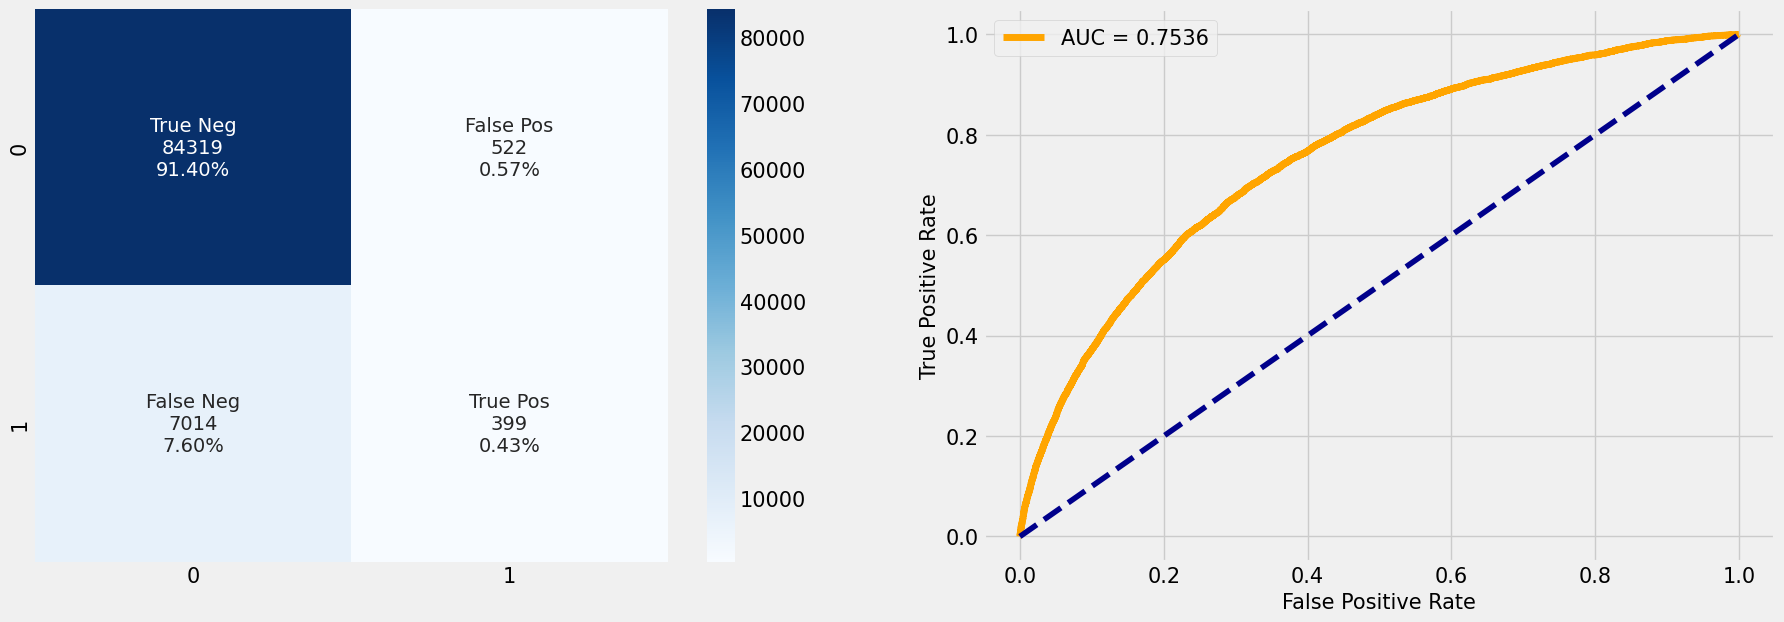

In [66]:
train_model_smote(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'),final_data,X_train_smote,y_train_smote)

In [67]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_smote, X_test, y_train_smote, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 197845, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 68478
[LightGBM] [Info] Number of data points in the train set: 395690, number of used features: 306
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 115 dense feature groups (43.77 MB) transferred to GPU in 0.046046 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
CPU times: total: 2min 28s
Wall time: 1min 25s


In [68]:
models_res

Model       AUC  Accuracy Precision    Recall        F1  \
0  CatBoostClassifier   0.76349  0.919808  0.518797  0.027924    0.8854   
2       XGBClassifier  0.753557  0.918312  0.433225  0.053824  0.888001   
1      LGBMClassifier  0.752946  0.919223  0.442136    0.0201  0.883964   

       Time  
0  67.74714  
2  9.035611  
1  9.108158

In [69]:
mlflow.end_run()

**Conclusion:** Le Catboost et le XGBCLassifier semblent plus performants avec les données SMOTE cependant le LightGBM reste raisonnable pour les 2 types de données.



# 6. Features Selection - Recursive Feature Elimination 

Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec LGBMClassifier qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [70]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 312 features.
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27720
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 304
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
Fitting estimator with 307 features.
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27708
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 299
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> init

In [71]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 182
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True False
 False  True False  True False  True  True  True]
Feature Ranking : [1 1 1 1 1 1 1 1 1 1 1 7 7 1 7 1 3 1 1 1]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1 : 

In [72]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

182
['CNT_CHILDREN', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_OTHER_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY', 'PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL', 'PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE', 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MATURE_CUM', 'PREV_APPL_MEAN_CARD_MEAN_SK_DPD', 'PREV_APPL_MEAN_CARD_MEAN_SK_DPD_DEF', 'PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION', 'PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 'PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT', 'PREV_APPL

In [73]:
rfecv.cv_results_

{'mean_test_score': array([0.64782878, 0.67117896, 0.75009971, 0.75597659, 0.75915974,
        0.76124184, 0.76268736, 0.76366251, 0.76417511, 0.76431011,
        0.76666614, 0.7679737 , 0.76901064, 0.77014322, 0.77009485,
        0.77031549, 0.77039598, 0.77049647, 0.77049078, 0.77095066,
        0.77055204, 0.77078227, 0.77113706, 0.77095677, 0.77064787,
        0.77139367, 0.77129754, 0.7710637 , 0.77127938, 0.77080076,
        0.77063015, 0.77089724, 0.77117261, 0.77088163, 0.77105478,
        0.77097353, 0.77128741, 0.77156541, 0.77102579, 0.77085253,
        0.77072431, 0.77089195, 0.7711259 , 0.7711259 , 0.7711259 ,
        0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 ,
        0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 ,
        0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 ,
        0.7711259 , 0.7711259 , 0.7711259 , 0.7711259 ]),
 'std_test_score': array([0.03597192, 0.00657161, 0.00350897, 0.00279732, 0.00230942,
        0.00236446, 0

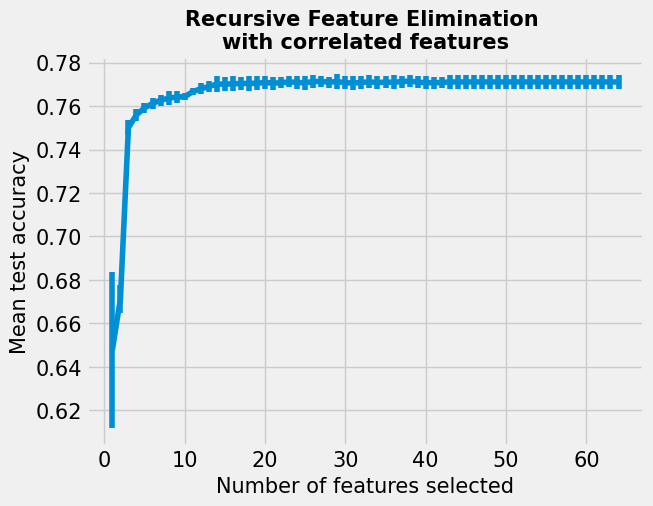

In [74]:
#Plot number of features vs CV scores
import matplotlib.pyplot as plt

min_features_to_select = 1  
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [75]:
#X_data is very important to implement the feature importance plot...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 182)

### Sauvegarde de X_data

In [76]:
TARGET2.head()

TARGET2
SK_ID_CURR         
0.000000        1.0
0.000003        0.0
0.000006        0.0
0.000011        0.0
0.000014        0.0

In [77]:
# Drop 'TARGET2' column from X_data if it exists to avoid duplication
target2_colname = TARGET2.columns[0]
if target2_colname in X_data.columns:
    X_data.drop(columns=[target2_colname], inplace=True)

# Merge X_data with TARGET2 on indices
X_data = pd.concat([X_data, TARGET2], axis=1)

# Check the final shape
print(X_data.shape)  # Should print (307511, 183)






(307511, 183)


In [78]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('X_data.zip', index=True, compression=compression_opts)

CPU times: total: 58.8 s
Wall time: 1min 53s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 182 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [79]:
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('X_sample.zip', index=True, compression=compression_opts)

CPU times: total: 5.67 s
Wall time: 8.68 s


In [80]:
%%time
X_data.sample(10000).to_csv('X_sample.csv', index=True)

CPU times: total: 1.08 s
Wall time: 1.61 s


## Transforming Data

In [81]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [82]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methods
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output

## Model evaluation

In [83]:
mlflow.set_experiment('Recursive_feature_selection_experiments')

2023/11/05 11:35:48 INFO mlflow.tracking.fluent: Experiment with name 'Recursive_feature_selection_experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/115792746486356577', creation_time=1699180548961, experiment_id='115792746486356577', last_update_time=1699180548961, lifecycle_stage='active', name='Recursive_feature_selection_experiments', tags={}>

In [84]:
def train_model_rfe(model, data, X_data, X_train_selected, X_test_selected, y_train, y_test):
    train, test = train_test_split(data, test_size=0.3, random_state=42)
    
    # train and test
    X_train = X_train_selected
    X_test = X_test_selected
    y_train = y_train
    y_test = y_test
    
    with mlflow.start_run():
        
        trained_model = model.fit(X_train, y_train)
        predicted_qualities = trained_model.predict(X_test)
    
        # Evaluation metrics
        (rmse, mae, r2) = eval_metrics(y_test, predicted_qualities)
        accuracy = accuracy_score(y_test, predicted_qualities)
        precision = precision_score(y_test, predicted_qualities)
        recall = recall_score(y_test, predicted_qualities)
        f_one = metrics.f1_score(y_test, predicted_qualities, average='weighted')
        
        # print("Model used:" % str(model))
        print(" RMSE: %s" % rmse)
        print(" MAE:%s" % mae)
        print(" R2:%s" % r2)
        print(" Accuracy: %s" % accuracy)
        print(" Precision:%s" % precision)
        print(" Recall:%s" % recall)
        print(" F-1 Score: %s" % f_one)
       
        roc_auc = roc_auc_score(y_test, trained_model.predict_proba(X_test)[:,1])
        print('AUC : %0.4f' %roc_auc)
        print(classification_report(y_test, trained_model.predict(X_test)))
        cf_matrix_roc_auc(model, y_test, trained_model.predict(X_test), trained_model.predict_proba(X_test)[:,1], None, roc_auc)
        
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("F-1 score", f_one)
        mlflow.log_metric("AUC", roc_auc)
        
        mlflow.sklearn.log_model(model, "model")
    
    return trained_model  # Return the trained model


 RMSE: 0.28251063247794944
 MAE:0.07981225746309104
 R2:-0.080040962444484
 Accuracy: 0.9201877425369089
 Precision:0.5631313131313131
 Recall:0.030082287872656144
 F-1 Score: 0.8859136869384283
AUC : 0.7753
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.56      0.03      0.06      7413

    accuracy                           0.92     92254
   macro avg       0.74      0.51      0.51     92254
weighted avg       0.89      0.92      0.89     92254



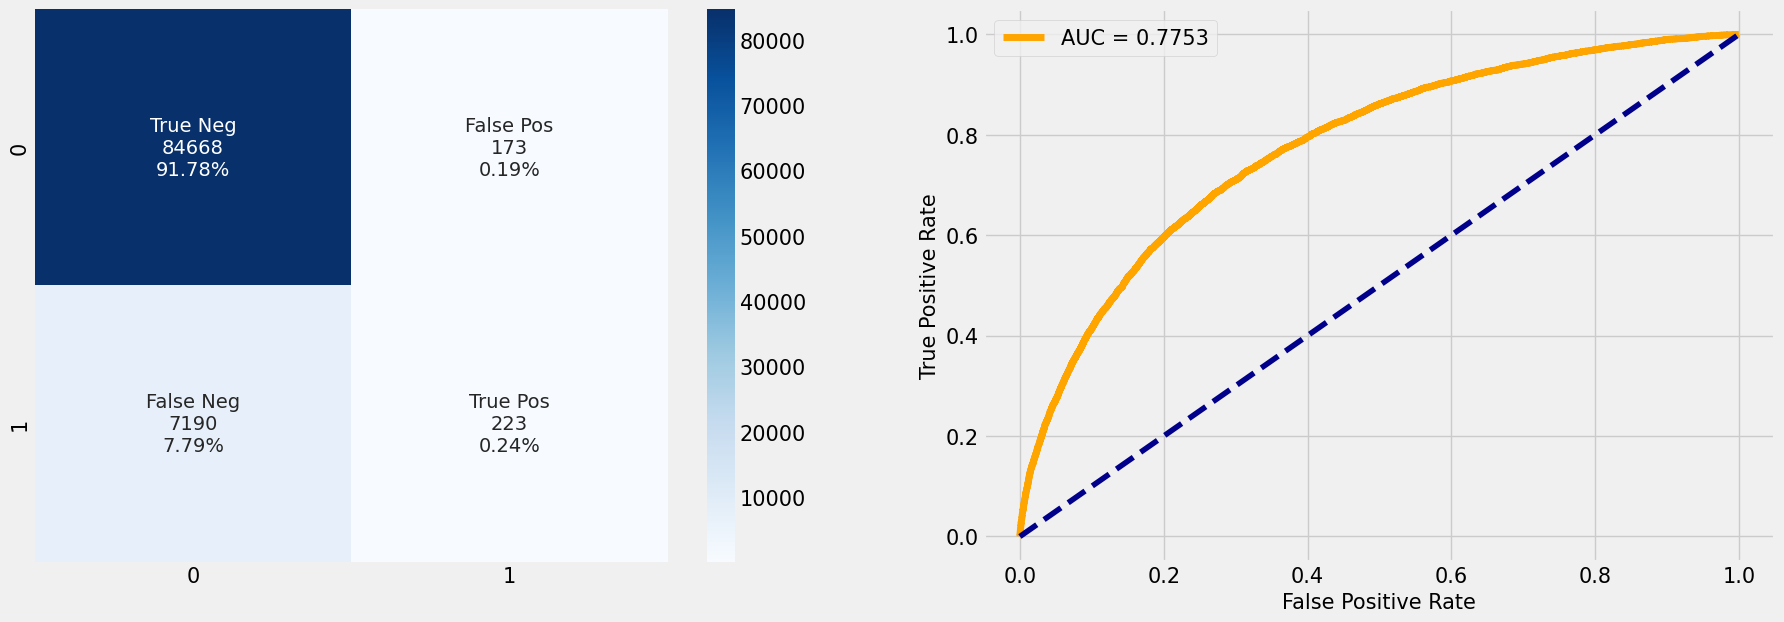

In [85]:
train_model_rfe(CatBoostClassifier(task_type="GPU", logging_level='Silent'),final_data,X_data,X_train_selected,X_test_selected,y_train,y_test)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 24735
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 182
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 90 dense feature groups (18.89 MB) transferred to GPU in 0.019707 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
 RMSE: 0.2827024121704441
 MAE:0.07992065384698767
 R2:-0.08150781150389519
 Accuracy: 0.9200793461530123
 Precision:0.5458715596330275
 Recall:0.03210576015108593
 F-1 Score: 0.8861366896865883
AUC : 0.7739
              precision    recall  f1-sco

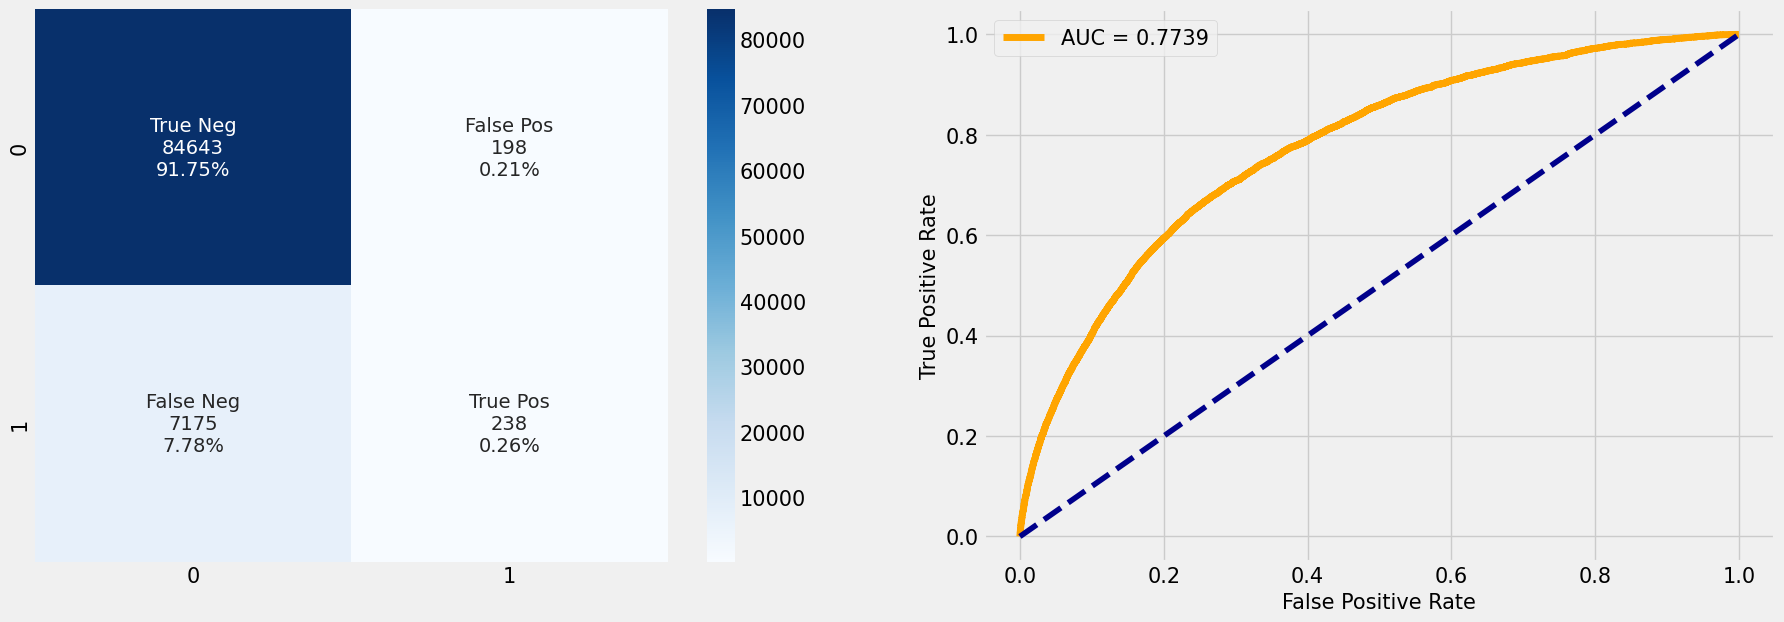

LGBMClassifier(device='gpu')

In [86]:
train_model_rfe(LGBMClassifier(device='gpu'),final_data,X_data,X_train_selected,X_test_selected,y_train,y_test)

 RMSE: 0.2850127191760693
 MAE:0.08123225009213693
 R2:-0.09925668512277097
 Accuracy: 0.918767749907863
 Precision:0.4562162162162162
 Recall:0.05692702009982463
 F-1 Score: 0.8886591712960227
AUC : 0.7667
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     84841
         1.0       0.46      0.06      0.10      7413

    accuracy                           0.92     92254
   macro avg       0.69      0.53      0.53     92254
weighted avg       0.89      0.92      0.89     92254



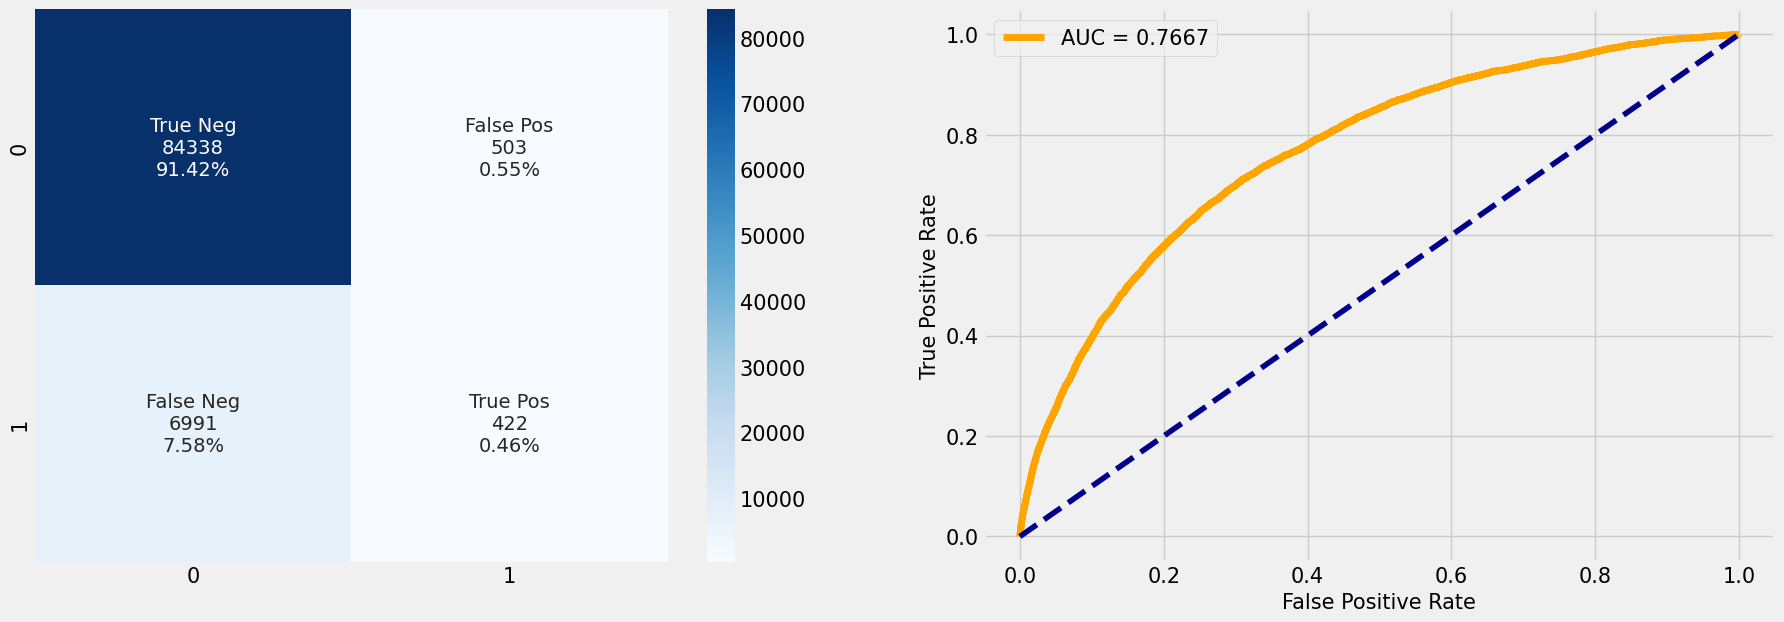

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, predictor='gpu_predictor', ...)

In [87]:
train_model_rfe(XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor'),final_data,X_data,X_train_selected,X_test_selected,y_train,y_test)

In [88]:
mlflow.end_run()

In [89]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 24735
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 182
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 90 dense feature groups (18.89 MB) transferred to GPU in 0.022781 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
CPU times: total: 50.8 s
Wall time: 22 s


In [90]:
#Models performance with features selection
models_rfe

Model       AUC  Accuracy Precision    Recall        F1  \
0  CatBoostClassifier  0.775302  0.920155  0.559194  0.029947   0.05685   
1      LGBMClassifier  0.773993  0.920036  0.541667  0.031566  0.059656   
2       XGBClassifier  0.766715  0.918768  0.456216  0.056927  0.101223   

       Time  
0  13.20414  
1   5.03347  
2  3.744981

**Conclusion**: 
LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time. CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

On développera maintenant La fonction coût, l'algorithme d'optimisation et la métrique d'évaluation. 

# 7. La fonction coût

La problématique est de prendre en compte qu’un faux positifs (bon client considéré comme mauvais = crédit non accordé à tort, donc manque à gagner de la marge pour la banque) n’a pas le même coût qu’un faux négatif (mauvais client à qui on accorde un prêt, donc perte sur le capital non remboursé). Un faux négatif est environ 10 fois plus coûteux qu’un faux positif. Les mesures techniques tels que le f1 score ne le prennent pas en compte. 

Le score “métier” consiste à calculer une fonction de coût métier de type 10*FN + FP (où FN = nombre de FN dans la matrice de confusion pour un seuil donné, FP = nombre de FP) et de trouver son minimum pour un seuil donné.

On peut se fixer l'hypothèse d'un Beta = 10. Vérifions-le avec une étape de tests fonctionnels.

In [91]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 10
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))
    
    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : -1.380952380952381
############################
Test 1 : [500, 300, 30, 10]
Score : -1.5821596244131455
############################
Test 2 : [400, 300, 70, 50]
Score : -1.0276497695852536
############################
Test 3 : [400, 300, 50, 70]
Score : -0.8723404255319149
############################
Test 4 : [350, 250, 80, 120]
Score : -0.43656716417910424
############################
Test 5 : [350, 250, 180, 90]
Score : -0.5524193548387097


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

In [92]:
def custom_score(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

In [93]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

# 8. Hyperparameters tunning - Hyperopt et AUC score///////

Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score et le custom score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.

Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [94]:
!pip install hyperopt


In [95]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [96]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [97]:
%%time
# General modules
import numpy as np

# Hyperopt modules for hyperparameter optimization
from hyperopt import fmin, tpe, space_eval, STATUS_OK, Trials, hp

# LightGBM and other model training related modules
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

# NOTE: The function `custom_score` which is called in the objective function is not provided in the code snippet.
# Make sure you have defined this function or replace it with an appropriate scoring metric.


# Given objective function
def objective(params, eval_metric='roc_auc'):
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device': 'gpu'}
  
    model = LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

# Hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.1)),
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.001), np.log(10))
}

SEED = 42




# Running the optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=np.random.default_rng(SEED)
)

# Calculating the total time taken for all trials
total_time = trials.trials[-1]['book_time'] - trials.trials[0]['book_time']
average_time = total_time.total_seconds() / len(trials.trials)

# Printing the results
print(f"100%|██████████| 30/30 [{total_time}<00:00, {average_time:.2f}s/trial, best loss: {trials.best_trial['result']['loss']}]")





# Updated Hyperparameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 500, 1),  # Reduced the upper limit
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),  # Start from a bit higher value
    'max_depth': hp.quniform('max_depth', 2, 10, 1),  # Reduced the upper limit
    'subsample': hp.uniform('subsample', 0.5, 0.9),  # Reduced the upper limit
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),  # Reduced the upper limit
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.01), np.log(5))  # Increased the lower limit
}


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276
[LightGBM] [Info] This is the GPU trainer!!           
[LightGBM] [Info] Total Bins 27662                    
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 303
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built        
[LightGBM] [Info] Size of histogram bin entry: 8      
[LightGBM] [Info] 101 dense feature groups (17.08 MB) transferred to GPU in 0.015709 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.4303

In [98]:
!pip install --upgrade ipython


In [99]:
mlflow.set_experiment('Optimized_lightboost_with_rfe_and_custom_score')

2023/11/05 12:10:16 INFO mlflow.tracking.fluent: Experiment with name 'Optimized_lightboost_with_rfe_and_custom_score' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/216662641494975892', creation_time=1699182616108, experiment_id='216662641494975892', last_update_time=1699182616108, lifecycle_stage='active', name='Optimized_lightboost_with_rfe_and_custom_score', tags={}>

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, f1_score

def train_model_optimized(model, data, X_data, X_train_selected, X_test_selected, y_train, y_test):
    train, test = train_test_split(data, test_size=0.3, random_state=42)
    
    # Assign train and test data
    X_train = X_train_selected
    X_test = X_test_selected
    y_train = y_train
    y_test = y_test
    
    with mlflow.start_run():
        # Train the model
        trained_model = model.fit(X_train, y_train)
        predicted_qualities = trained_model.predict(X_test)
    
        # Evaluation metrics
        accuracy = accuracy_score(y_test, predicted_qualities)
        precision = precision_score(y_test, predicted_qualities)
        recall = recall_score(y_test, predicted_qualities)
        f_one = f1_score(y_test, predicted_qualities, average='weighted')
        
        # Print metrics
        print(" Accuracy: %s" % accuracy)
        print(" Precision:%s" % precision)
        print(" Recall:%s" % recall)
        print(" F-1 Score: %s" % f_one)
       
        # ROC AUC
        roc_auc = roc_auc_score(y_test, trained_model.predict_proba(X_test)[:,1])
        print('AUC : %0.4f' %roc_auc)
        
        # Classification report & confusion matrix
        print(classification_report(y_test, trained_model.predict(X_test)))
        cf_matrix_roc_auc(model, y_test, trained_model.predict(X_test), trained_model.predict_proba(X_test)[:,1], None, roc_auc)
        
        # Log metrics with mlflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("F-1 score", f_one)
        mlflow.log_metric("AUC", roc_auc)
        
        # Log the model
        mlflow.sklearn.log_model(model, "model")
    
    return trained_model  # Return the trained model


In [101]:
lgbm = LGBMClassifier(
    n_estimators=int(best['n_estimators']), 
    colsample_bytree=best['colsample_bytree'],
    learning_rate=best['learning_rate'],
    max_depth=int(best['max_depth']),
    subsample=best['subsample'],
    reg_lambda=best['reg_lambda'],
    num_leaves=2**int(best['max_depth']),  # setting num_leaves explicitly
    device='gpu'
)


[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 24735
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 182
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 90 dense feature groups (18.89 MB) transferred to GPU in 0.020962 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score -2.430324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

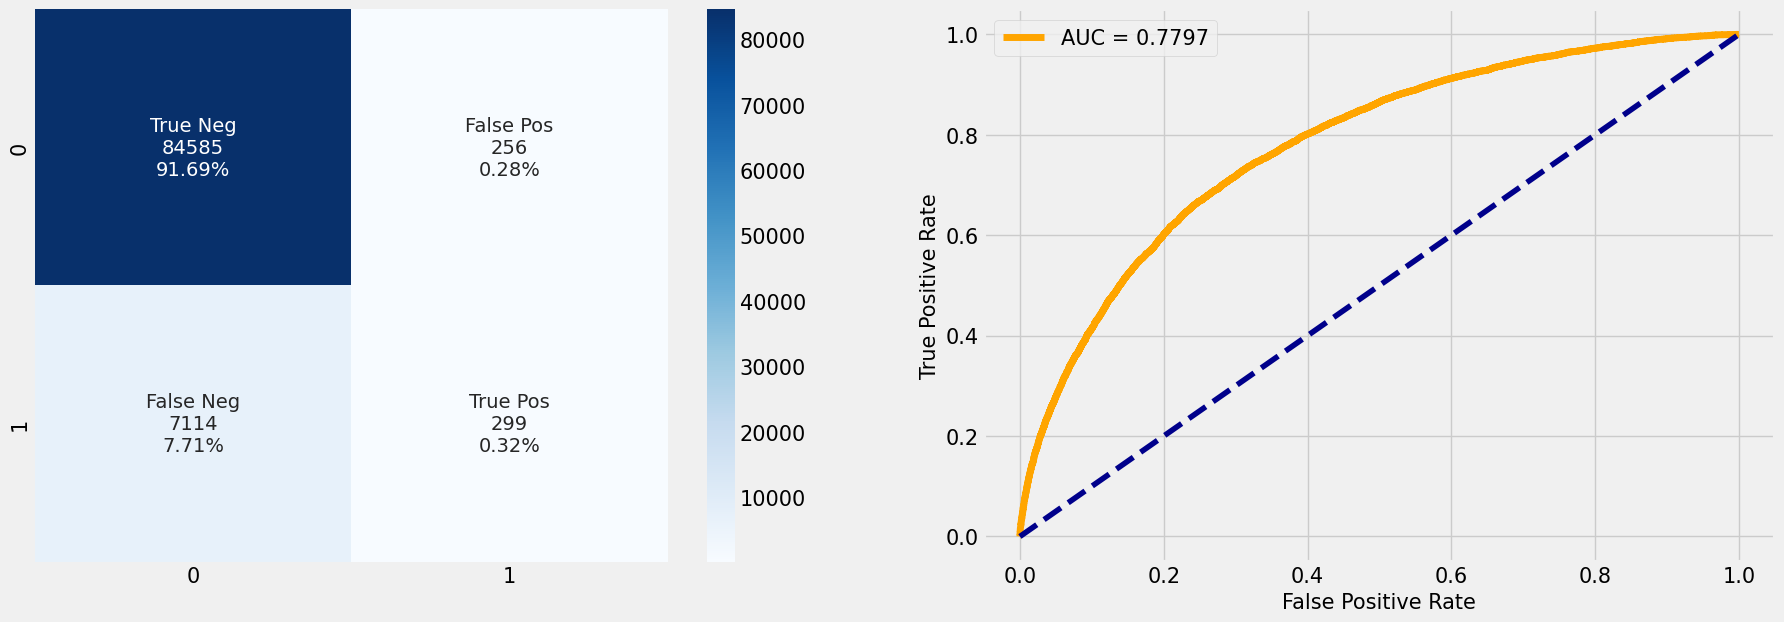

LGBMClassifier(colsample_bytree=0.8053123197476432, device='gpu',
               learning_rate=0.0414540464825754, max_depth=6, n_estimators=613,
               num_leaves=64, reg_lambda=0.8320671979744699,
               subsample=0.6415804690150524)

In [102]:
train_model_optimized(lgbm,final_data,X_data,X_train_selected,X_test_selected,y_train,y_test)

In [103]:
%%time

lgbm = LGBMClassifier(
    n_estimators=int(best['n_estimators']), 
    colsample_bytree=best['colsample_bytree'],
    learning_rate=best['learning_rate'],
    max_depth=min(10, int(best['max_depth'])),  # Restricting max_depth to be at most 10
    subsample=best['subsample'],
    reg_lambda=max(0.1, best['reg_lambda']),  # Increasing regularization slightly
    num_leaves=min(2**int(best['max_depth']), 31),  # setting num_leaves explicitly, and ensuring it doesn't exceed 31
    device='gpu'
)

lgbm.fit(X_train_selected, y_train)
import pickle
pickle.dump(lgbm, open("LGBMClassifier.pkl", "wb"))



[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 24735
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 182
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 90 dense feature groups (18.89 MB) transferred to GPU in 0.032761 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score

In [104]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.780563


In [105]:
from sklearn.metrics import confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances, roc_auc):
    '''This function will make a pretty plot of
    an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))

    # Plotting confusion matrix
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    # Plotting ROC curve
    plt.subplot(222)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # This part assumes that the model has a 'feature_importances_' attribute
    if feature_importances:
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
        # Uncomment the following lines if you want to plot feature importances
        # features = [X_data.columns[i] for i in indices[:20]]
        # sns.barplot(x=features, y=model.feature_importances_[indices[:20]], color="orange")
        # plt.xlabel('Features importance')
        # plt.xticks(rotation=90)

    plt.show()


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


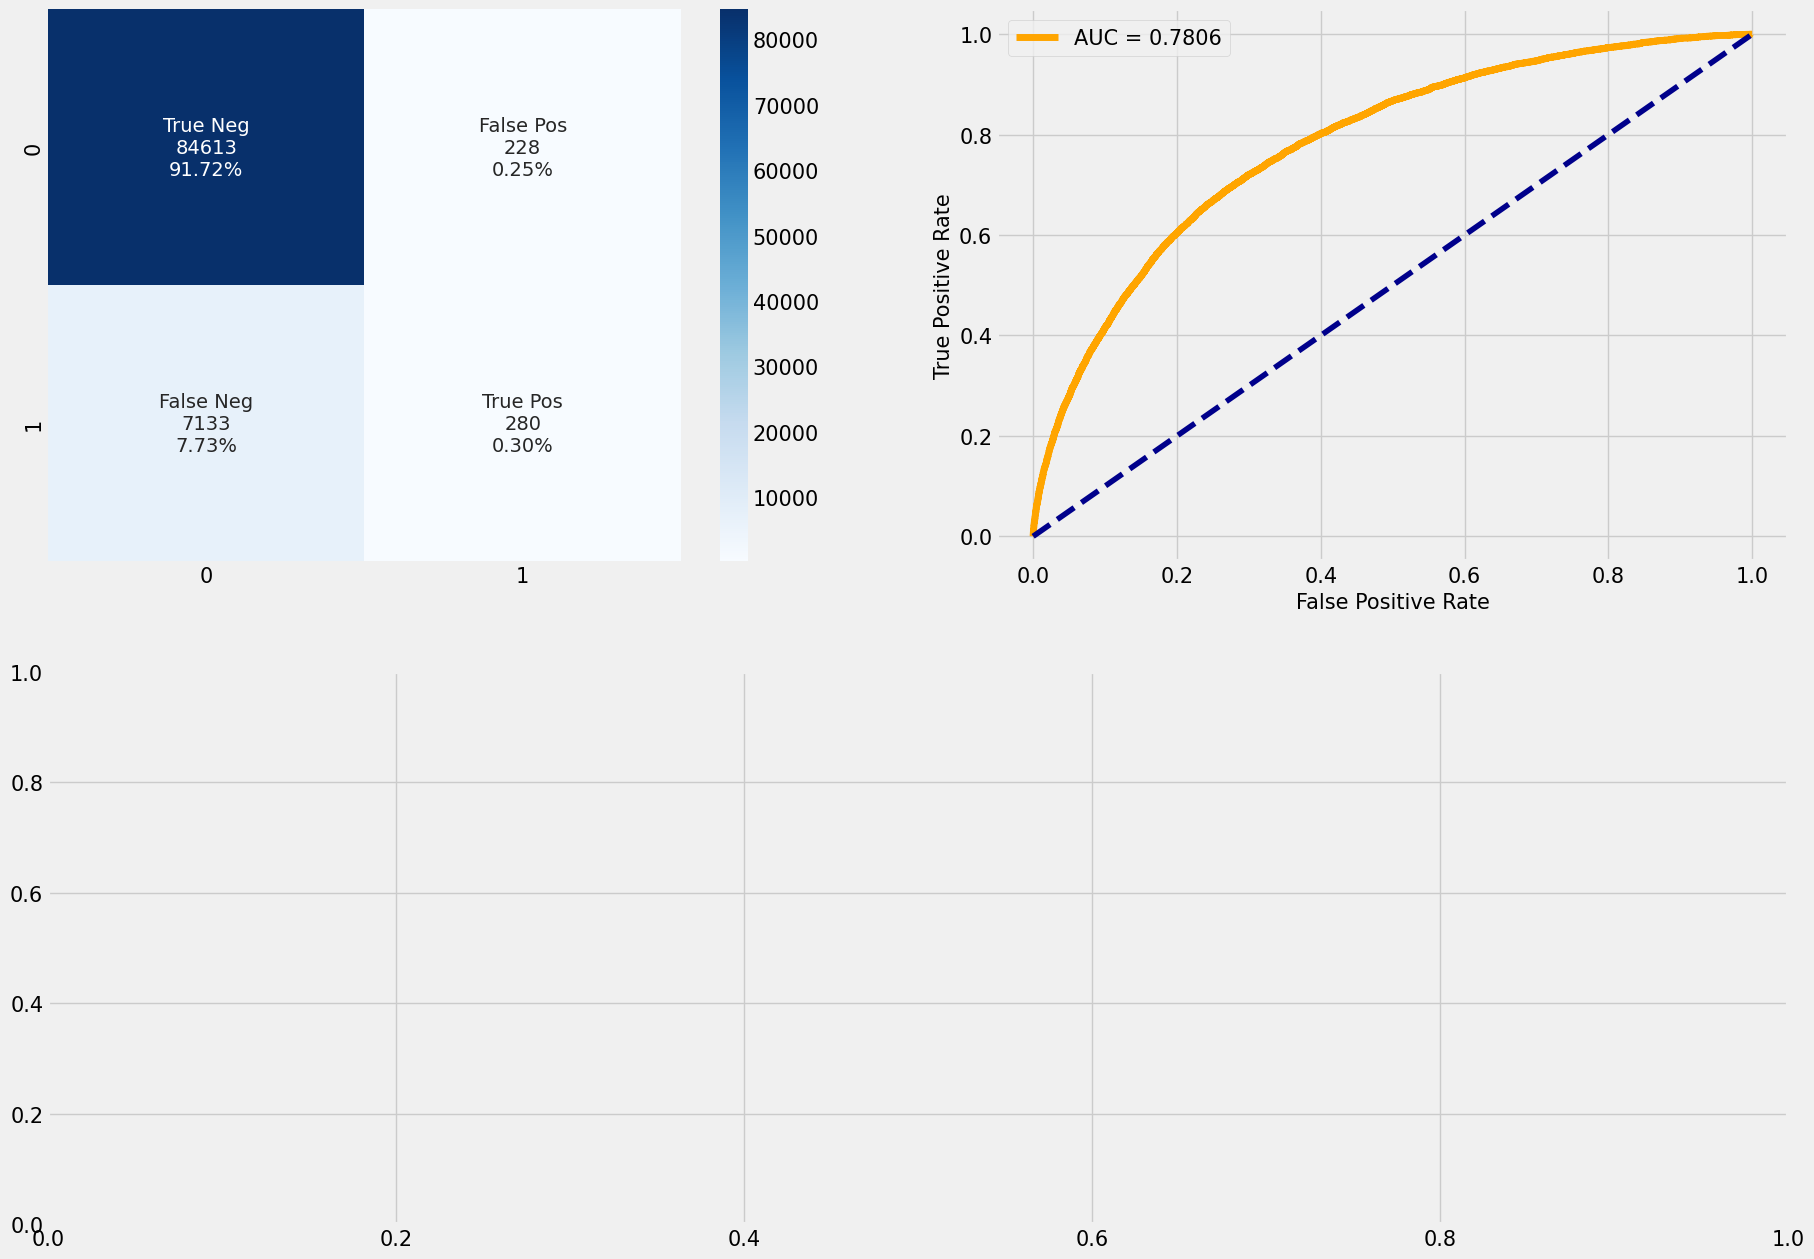

In [106]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], True, roc_auc)


In [107]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
False Pos: 0.25%
False Neg: 7.73%


(0.0024714375528432373, 0.07731914063346847)

In [108]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 695]
['EXT_SOURCE_2', 585]
['EXT_SOURCE_1', 543]
['EXT_SOURCE_3', 530]
['DAYS_BIRTH', 523]
['AMT_ANNUITY', 372]
['PREV_APPL_MEAN_CNT_PAYMENT', 367]
['DAYS_ID_PUBLISH', 365]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 342]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 317]
['DAYS_REGISTRATION', 311]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 307]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 301]
['ANNUITY_INCOME_PERCENT', 300]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 298]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 284]
['AMT_CREDIT', 282]
['PREV_BUR_MEAN_DAYS_CREDIT', 268]
['DAYS_LAST_PHONE_CHANGE', 262]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 260]
['DAYS_EMPLOYED', 259]
['AMT_GOODS_PRICE', 256]
['PREV_APPL_MEAN_AMT_ANNUITY', 256]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 255]
['PREV_BUR_MEAN_DAYS_ENDDATE_FACT', 239]
['CREDIT_INCOME_PERCENT', 226]
['PREV_BUR_MEAN_DAYS_CREDIT_UPDATE', 226]
['DAYS_EMPLOYED_PERCENT', 222]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION', 202]
['R

In [109]:
def objective(params, eval_metric='roc_auc'):
  #objective function to be minimized. 
  #Hyperopt will seek to minimize the loss returned by this function.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'}
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [110]:
%%time
best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.default_rng(SEED), algo=tpe.suggest)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 13929, number of negative: 158276
[LightGBM] [Info] This is the GPU trainer!!           
[LightGBM] [Info] Total Bins 24682                    
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 182
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built        
[LightGBM] [Info] Size of histogram bin entry: 8      
[LightGBM] [Info] 90 dense feature groups (15.11 MB) transferred to GPU in 0.019843 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080886 -> initscore=-2.43036

In [111]:
lgbm_2 = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 24735
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 182
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 90 dense feature groups (18.89 MB) transferred to GPU in 0.033492 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score

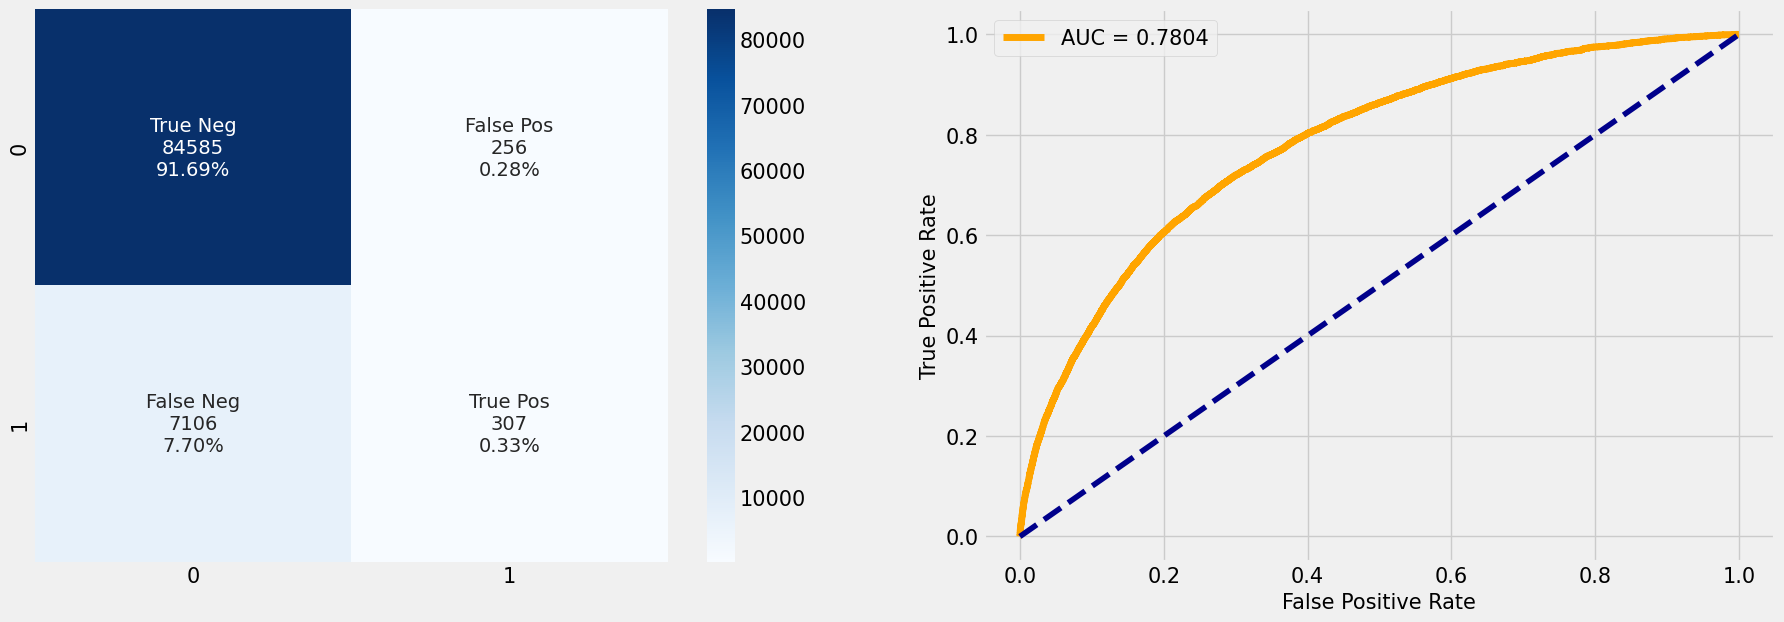

LGBMClassifier(colsample_bytree=0.5053281994981228, device='gpu',
               learning_rate=0.061158529114411435, max_depth=6,
               n_estimators=486, reg_lambda=0.0879594586381435,
               subsample=0.7352914228773502)

In [112]:
train_model_optimized(lgbm_2,final_data,X_data,X_train_selected,X_test_selected,y_train,y_test)

In [113]:
mlflow.end_run()

In [114]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 17412, number of negative: 197845
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 24735
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 182
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 90 dense feature groups (18.89 MB) transferred to GPU in 0.096580 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080889 -> initscore=-2.430324
[LightGBM] [Info] Start training from score

LGBMClassifier(colsample_bytree=0.5053281994981228, device='gpu',
               learning_rate=0.061158529114411435, max_depth=6,
               n_estimators=486, reg_lambda=0.0879594586381435,
               subsample=0.7352914228773502)

In [115]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC : 0.780405


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


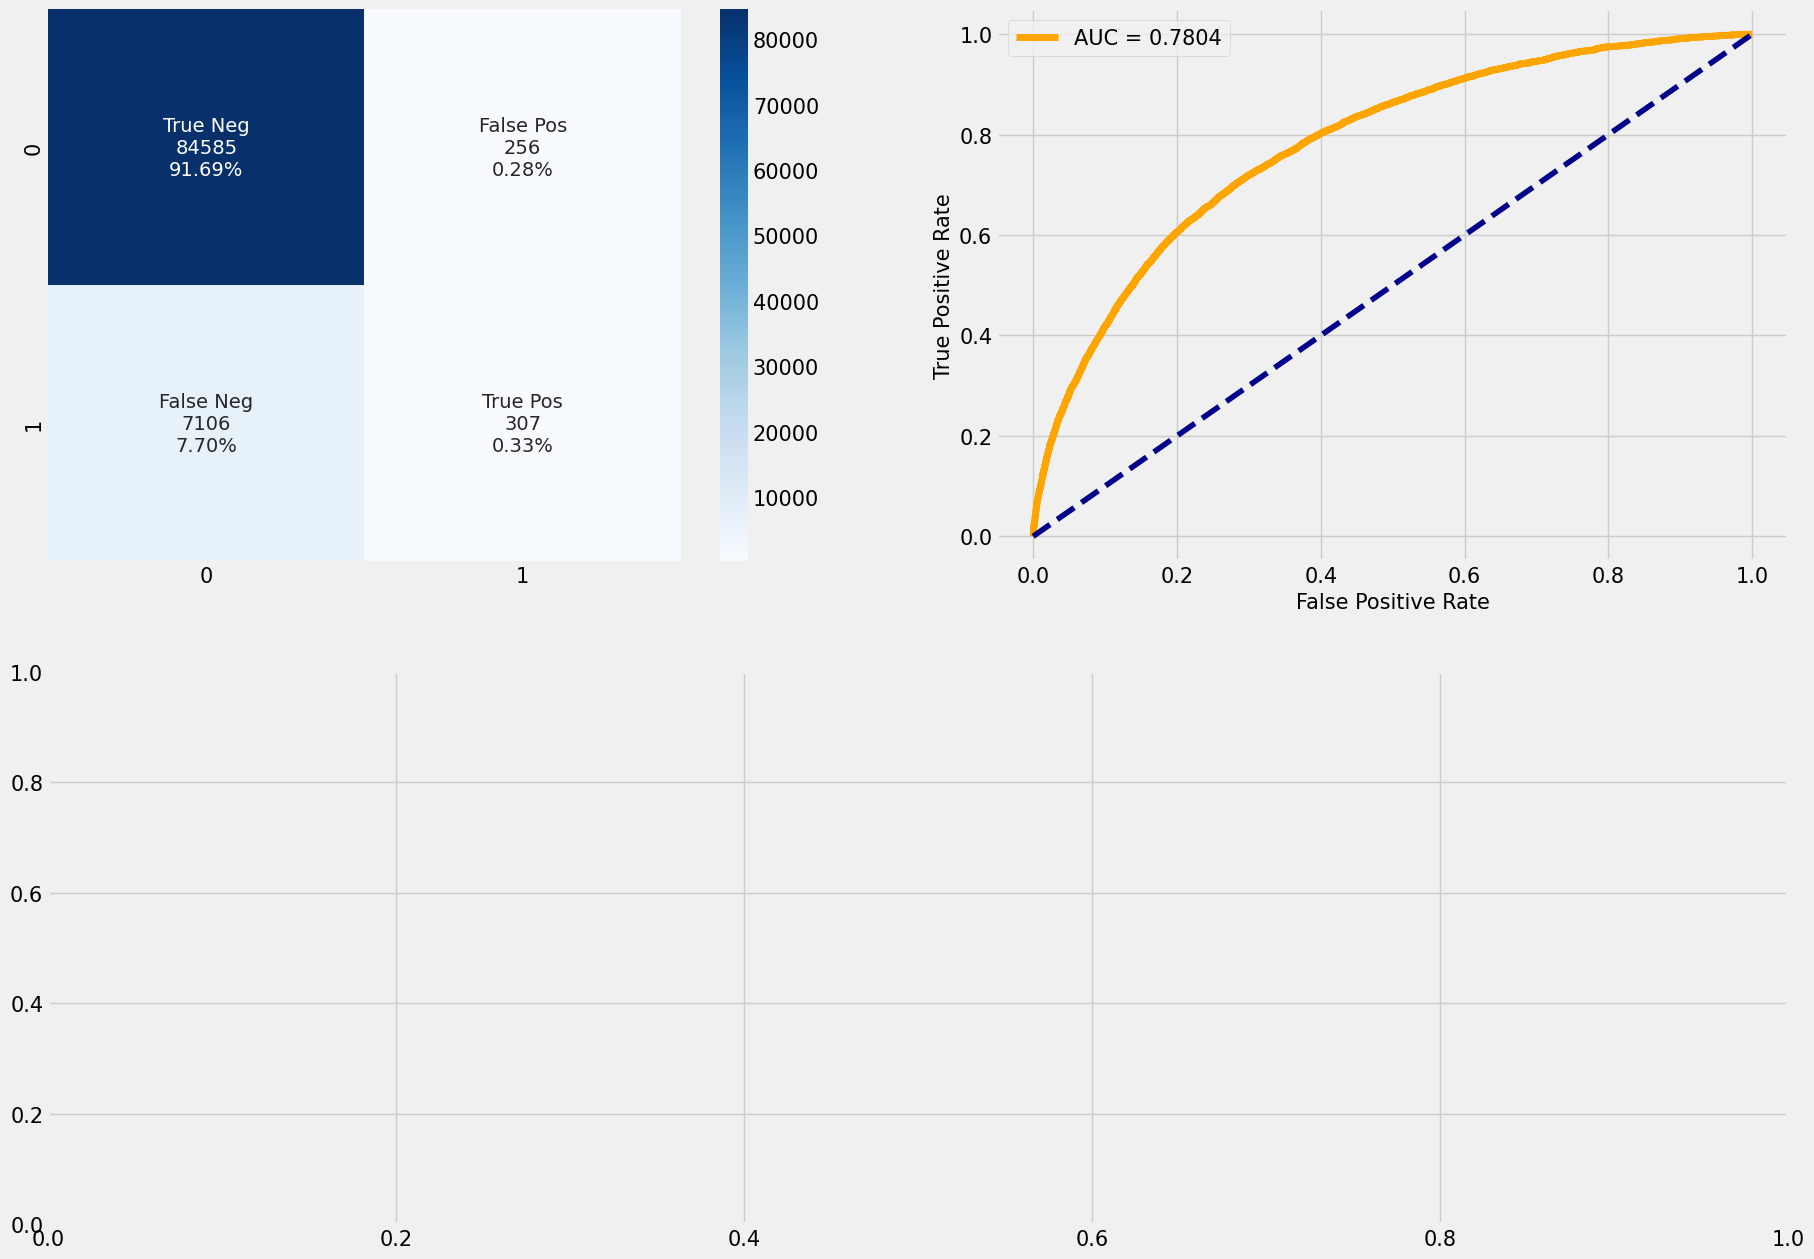

In [116]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], True, roc_auc)


In [117]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
False Pos: 0.28%
False Neg: 7.70%


(0.00277494742775381, 0.07702647039694756)

In [118]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 523]
['EXT_SOURCE_1', 374]
['EXT_SOURCE_3', 351]
['DAYS_BIRTH', 332]
['EXT_SOURCE_2', 318]
['DAYS_ID_PUBLISH', 296]
['PREV_APPL_MEAN_CNT_PAYMENT', 279]
['AMT_ANNUITY', 277]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 258]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 255]
['DAYS_REGISTRATION', 240]
['ANNUITY_INCOME_PERCENT', 238]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 238]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 236]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 235]
['AMT_CREDIT', 230]
['AMT_GOODS_PRICE', 218]
['PREV_APPL_MEAN_AMT_ANNUITY', 211]
['PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 204]
['DAYS_LAST_PHONE_CHANGE', 200]
['DAYS_EMPLOYED_PERCENT', 197]
['PREV_BUR_MEAN_DAYS_CREDIT', 197]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 195]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 195]
['CREDIT_INCOME_PERCENT', 195]
['PREV_BUR_MEAN_DAYS_CREDIT_UPDATE', 194]
['PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 189]
['DAYS_EMPLOYED', 188]
['REGION_POPULATION_RELATIVE', 172]
['PREV_APPL_MEAN_A

In [119]:
print(X_data)

            CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
0.000000             0.0          0.001512    0.090287     0.090032   
0.000003             0.0          0.002089    0.311736     0.132924   
0.000006             0.0          0.000358    0.022472     0.020025   
0.000011             0.0          0.000935    0.066837     0.109477   
0.000014             0.0          0.000819    0.116854     0.078975   
...                  ...               ...         ...          ...   
0.999989             0.0          0.001127    0.052360     0.101176   
0.999992             0.0          0.000396    0.056067     0.040505   
0.999994             0.0          0.001089    0.157969     0.110618   
0.999997             0.0          0.001243    0.081175     0.072499   
1.000000             0.0          0.001127    0.157303     0.185258   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID

# Conclusion
Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.72 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 3 algorithmes plus complexes de gradient boosting implémentés par LightGbm vs CatBoost vs XGBoost. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à l'origine > 300, après RFECV 149. LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC, il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier les FP sont estimés à 0.19% (contre 0.21%), les FN sont à 0.78% (contre 0.77%). Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.

In [120]:
# open mlflowruns in jupyter notebook home or in terminal with mlflow ui
#class weight = balance pour xgboost sans le smote 
#score personalisé qui pénalise le modèle plus quand un client ne paye pas
#Valeurs manquantes à tester plussieurs autres possibilités